In [124]:
library(circlize)
library(colorspace)
library(ComplexHeatmap)

In [126]:
FlyPhoneDB <- read_excel("FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

# WTLD

In [8]:
options(repr.plot.res = 500)   # resolution in DPI

# Make background white
par(bg = "white")


Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'ALG', track '2'.

Note: 1 point is out of plotting region in sector 'ALG', track '2'.

Note: 1 point is out of plotting region in sector 'AudSN', track '2'.

Note: 1 point is out of plotting region in sector 'AudSN', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CHG', track '2'.

Note: 1 point is out of plotting region in sector 'CHG', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plotting region in sector 'CLKN', track '2'.

Note: 1 point is out of plot

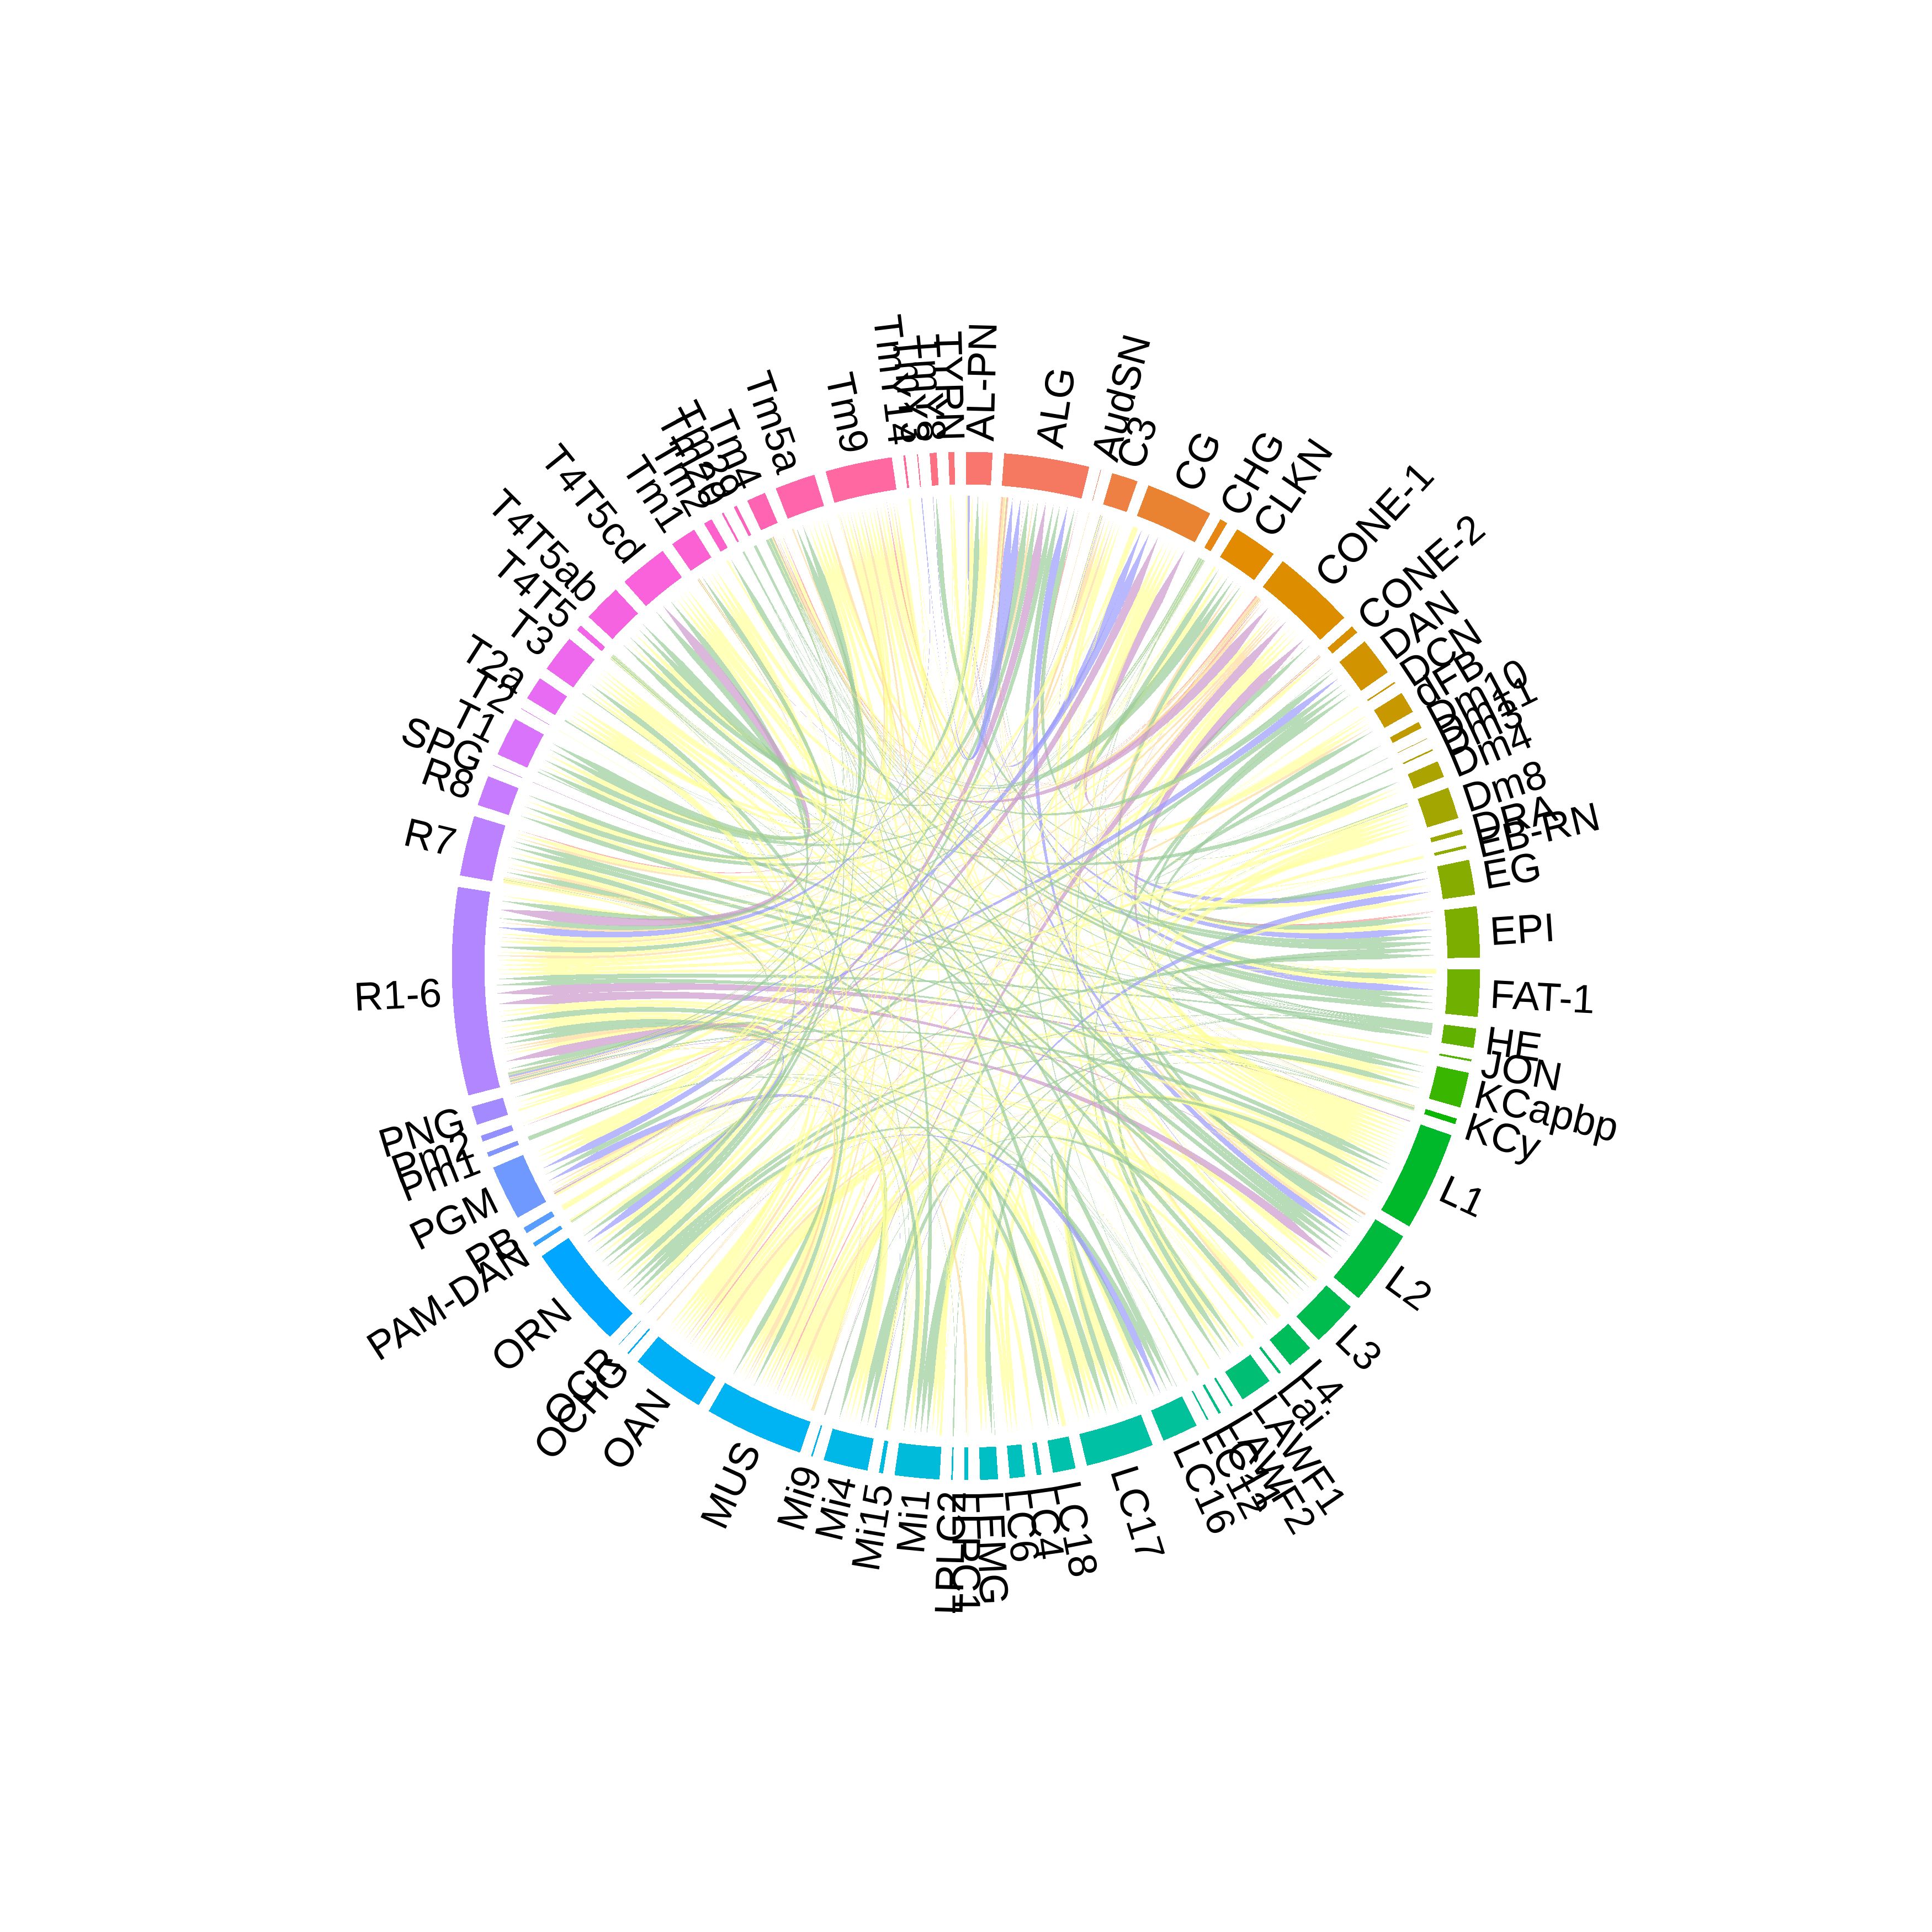

In [127]:
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)
library(stringr)

# Make background white
par(bg = "white")

#-----------------------------------------------------------
# 1. Read in your data for MTDD and FlyPhoneDB
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/WTLD_combined.csv")
FlyPhoneDB <- read_excel("FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx", skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from MTDD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}
combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)

#-----------------------------------------------------------
# 5. Aggregate interactions by cell type pairs
agg_df <- combined_df %>%
  group_by(ligand_cell_type, receptor_cell_type) %>%
  summarise(interaction_count = n(),
            avg_ligand_LAG = mean(ligand_LAG),
            .groups = "drop")

# Remove self-communication (only inter-cell interactions)
agg_df <- agg_df %>%
  filter(trimws(ligand_cell_type) != trimws(receptor_cell_type))

#-----------------------------------------------------------
# 6. Binning time and mapping chord colors
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4", "ZT4-8", "ZT8-12", "ZT12-16", "ZT16-20", "ZT20-24")
agg_df <- agg_df %>%
  mutate(time_bin = cut(
    avg_ligand_LAG,
    breaks = bin_breaks,
    labels = bin_labels,
    include.lowest = TRUE,
    right = FALSE
  ))

bin_colors <- c("#ff9999", "#ffdb99", "#ffff99", "#99cc99", "#9999ff", "#cc99cc")
names(bin_colors) <- bin_labels
agg_df$col <- bin_colors[agg_df$time_bin]

#-----------------------------------------------------------
# 7. Prepare data for chordDiagram:
df_chord <- agg_df %>%
  rename(from = ligand_cell_type,
         to   = receptor_cell_type,
         value = interaction_count)

# Apply alpha transparency (0.7) to chord colors.
df_chord$col <- alpha(df_chord$col, 0.7)

#-----------------------------------------------------------
# 8. Sort cell types alphabetically and assign a HUSL-like palette.
sector_names <- sort(union(df_chord$from, df_chord$to))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

#-----------------------------------------------------------
dynamic_gap <- 1.3

#-----------------------------------------------------------
# 11. Set circlize parameters using the computed dynamic_gap:
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)
par(cex = 1.1)  # reduce font size

#-----------------------------------------------------------
# 12. Draw the chord diagram with directional arrows:
chordDiagram(
  x = df_chord,
  order = names(sector_colors),  # Ensure order matches the names in grid.col.
  grid.col = sector_colors,      # HUSL-like palette for sectors.
  col = df_chord$col,            # Chord colors based on time bins.
  directional = 1,
  direction.type = c("arrows"),
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$value / max(df_chord$value, na.rm = TRUE) * 5,
  transparency = 0.8,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.05)
)

#-----------------------------------------------------------
# 13. Add custom sector labels:
circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

#-----------------------------------------------------------
# 14. Add a legend for the time bin colors:
lgd_bins <- Legend(
  labels = bin_labels,
  legend_gp = gpar(fill = bin_colors),
  title = "Time Bins"
)
#draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.9, "npc"))


In [31]:
options(repr.plot.width = 8,   # width in inches
        repr.plot.height = 8,  # height in inches
        repr.plot.res = 300)   # resolution in DPI


# WTDD

Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'AL-PN', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CHG', track '2'.

Note: 1 point is out of plotting region in sector 'CHG', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm10', track '2'.

Note: 1 point is out of plotting region in sector 'Dm8', track '2'.

Note: 1 point is out of plotting region in sector 'Dm8', track '2'.

Note: 1 point is out of plotting region in sector 'EB-RN', track '2'.

Note: 1 point is out of plotting region in sector 'EB-RN', track '2'.

Note: 1 point is out of plotting region in sector 'EG', track '2'.

Note: 1 point is out of plotting region in sector 'EG', track '2'.

Note: 1 point is out of plot

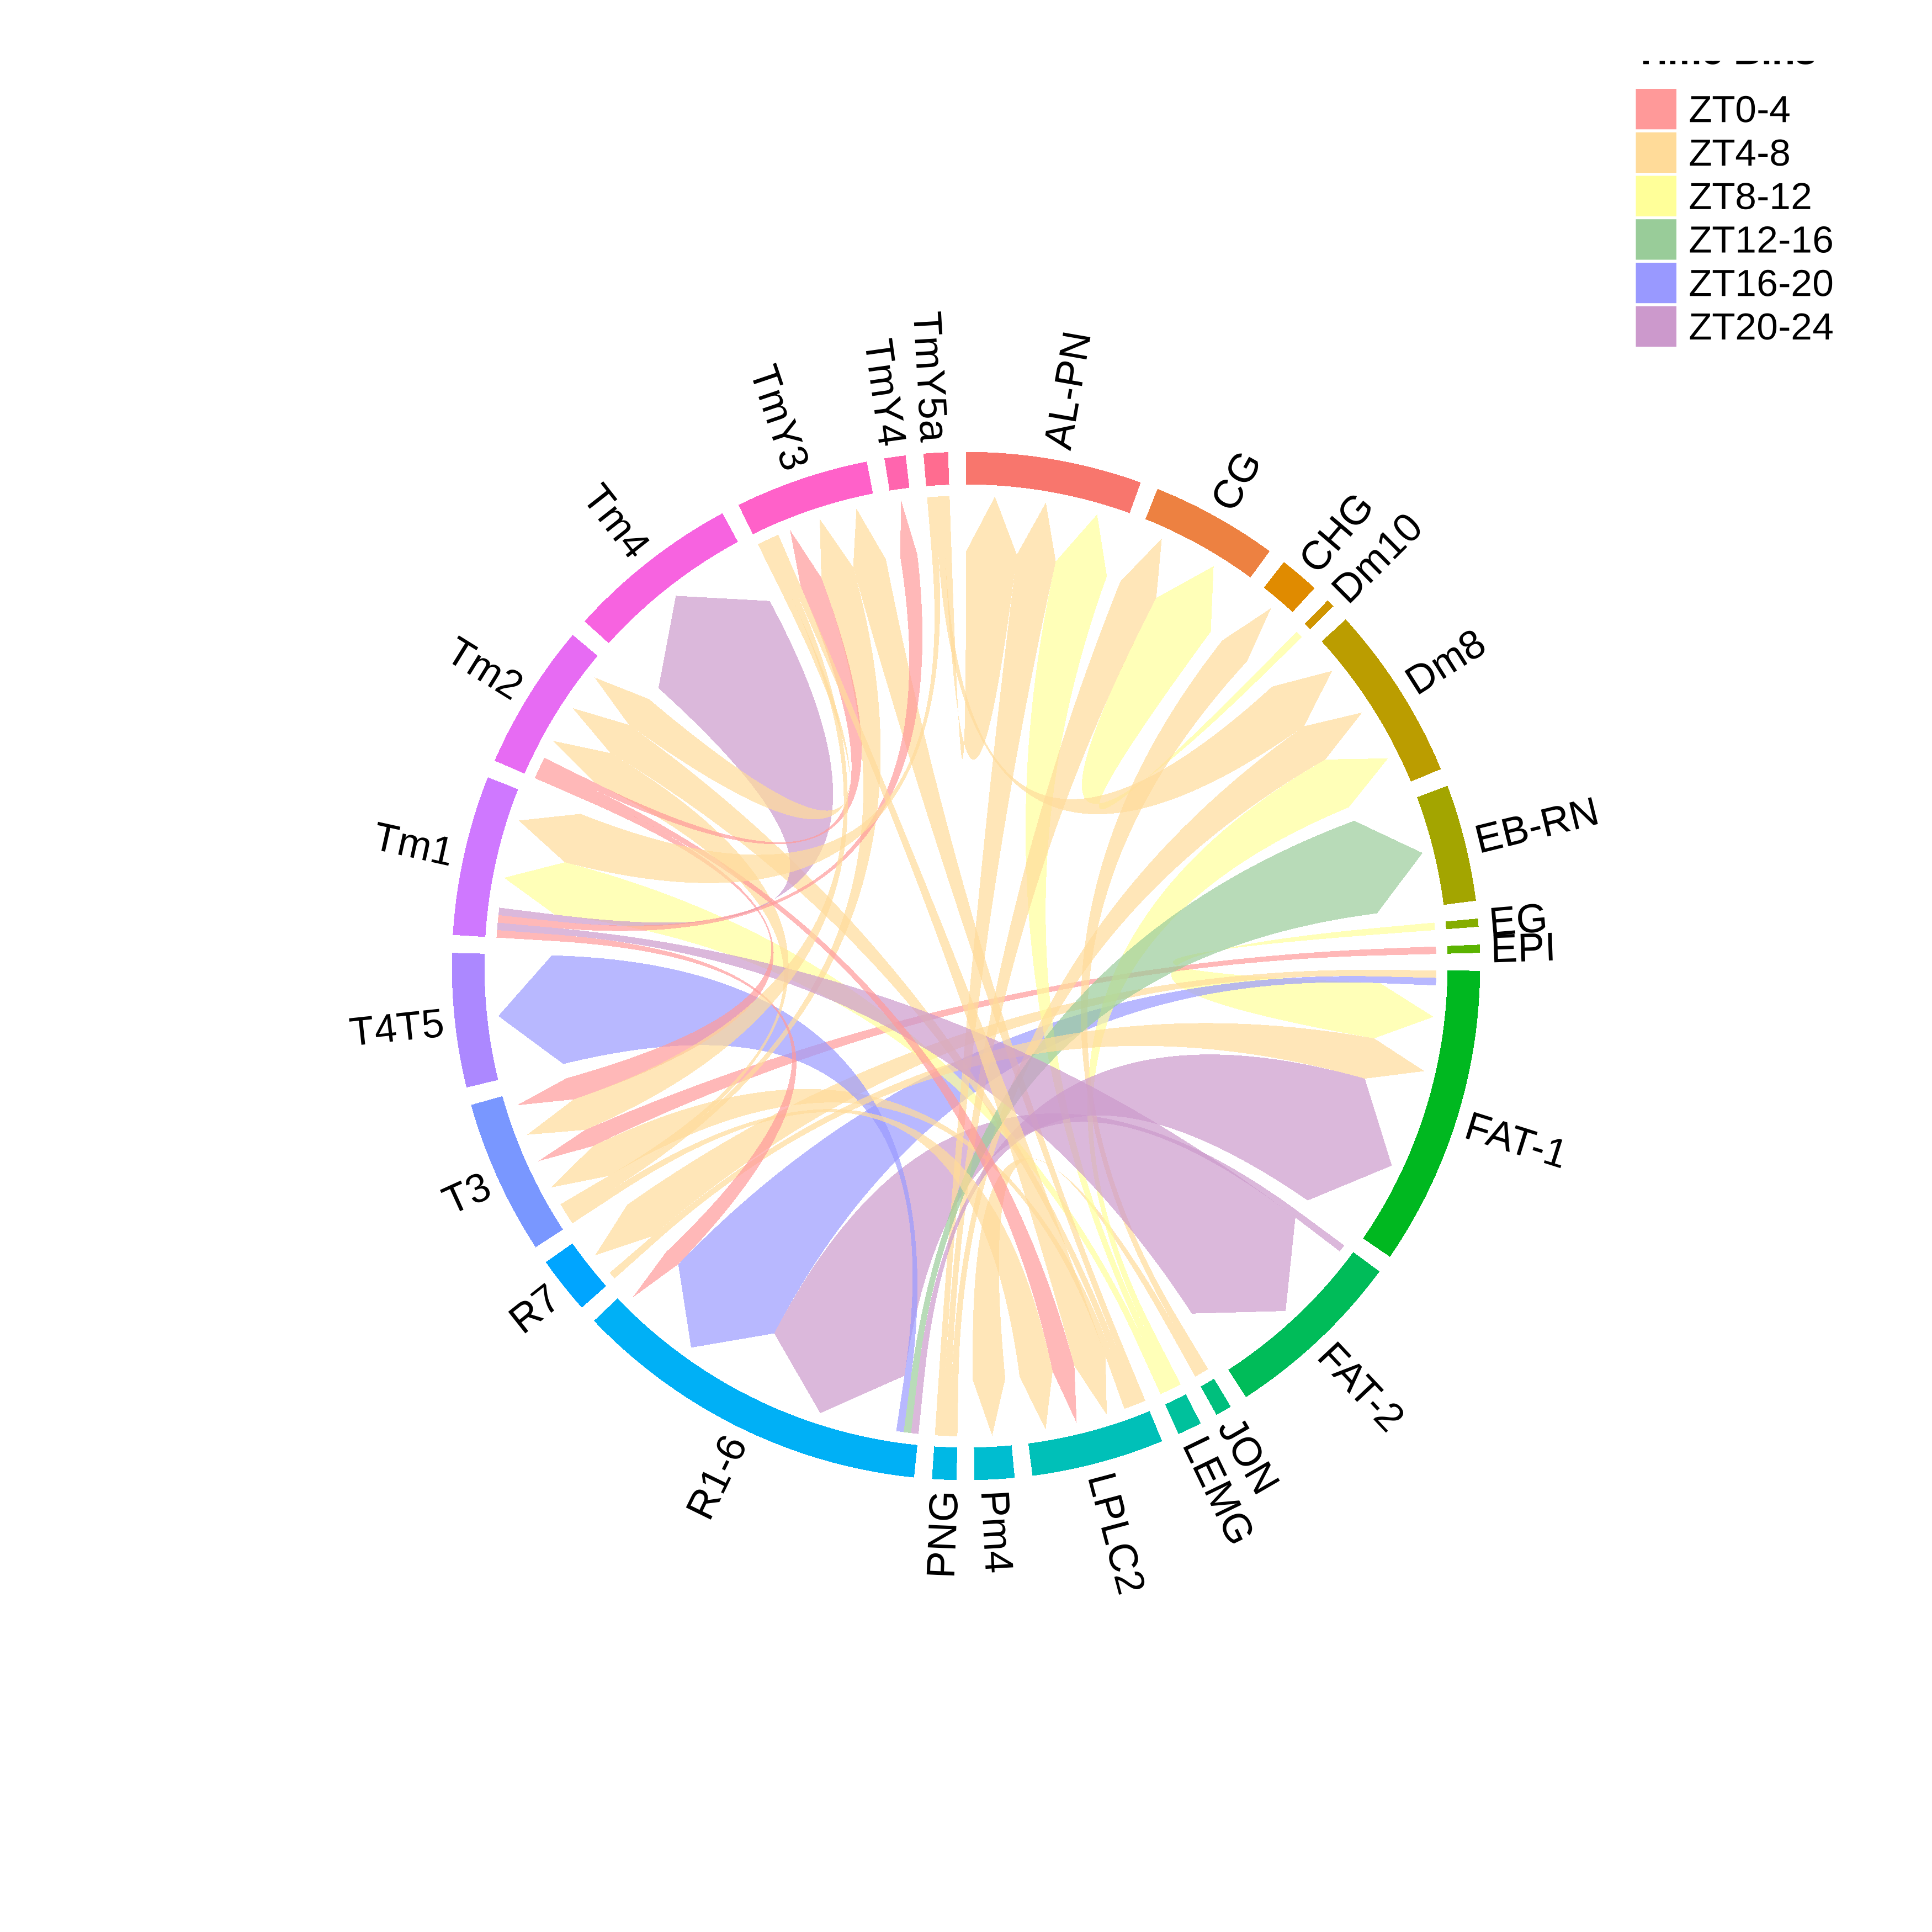

In [128]:
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)
library(stringr)

# Make background white
par(bg = "white")

#-----------------------------------------------------------
# 1. Read in your data for MTDD and FlyPhoneDB
WTDD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/WTDD_combined.csv")
FlyPhoneDB <- read_excel("FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx", skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from MTDD
WTDD <- WTDD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTDD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTDD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}
combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)

#-----------------------------------------------------------
# 5. Aggregate interactions by cell type pairs
agg_df <- combined_df %>%
  group_by(ligand_cell_type, receptor_cell_type) %>%
  summarise(interaction_count = n(),
            avg_ligand_LAG = mean(ligand_LAG),
            .groups = "drop")

# Remove self-communication (only inter-cell interactions)
agg_df <- agg_df %>%
  filter(trimws(ligand_cell_type) != trimws(receptor_cell_type))

#-----------------------------------------------------------
# 6. Binning time and mapping chord colors
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4", "ZT4-8", "ZT8-12", "ZT12-16", "ZT16-20", "ZT20-24")
agg_df <- agg_df %>%
  mutate(time_bin = cut(
    avg_ligand_LAG,
    breaks = bin_breaks,
    labels = bin_labels,
    include.lowest = TRUE,
    right = FALSE
  ))

bin_colors <- c("#ff9999", "#ffdb99", "#ffff99", "#99cc99", "#9999ff", "#cc99cc")
names(bin_colors) <- bin_labels
agg_df$col <- bin_colors[agg_df$time_bin]

#-----------------------------------------------------------
# 7. Prepare data for chordDiagram:
df_chord <- agg_df %>%
  rename(from = ligand_cell_type,
         to   = receptor_cell_type,
         value = interaction_count)

# Apply alpha transparency (0.7) to chord colors.
df_chord$col <- alpha(df_chord$col, 0.7)

#-----------------------------------------------------------
# 8. Sort cell types alphabetically and assign a HUSL-like palette.
sector_names <- sort(union(df_chord$from, df_chord$to))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

#-----------------------------------------------------------
dynamic_gap <- 2

#-----------------------------------------------------------
# 11. Set circlize parameters using the computed dynamic_gap:
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)
par(cex = 1.1)  # reduce font size

#-----------------------------------------------------------
# 12. Draw the chord diagram with directional arrows:
chordDiagram(
  x = df_chord,
  order = names(sector_colors),  # Ensure order matches the names in grid.col.
  grid.col = sector_colors,      # HUSL-like palette for sectors.
  col = df_chord$col,            # Chord colors based on time bins.
  directional = 1,
  direction.type = c("arrows"),
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$value / max(df_chord$value, na.rm = TRUE) * 5,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.05)
)

#-----------------------------------------------------------
# 13. Add custom sector labels:
circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

#-----------------------------------------------------------
# 14. Add a legend for the time bin colors:
lgd_bins <- Legend(
  labels = bin_labels,
  legend_gp = gpar(fill = bin_colors),
  title = "Time Bins"
)
draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.9, "npc"))


# MTLD

Note: 1 point is out of plotting region in sector 'ALG', track '2'.

Note: 1 point is out of plotting region in sector 'ALG', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C2', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'C3', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CG', track '2'.

Note: 1 point is out of plotting region in sector 'CONE-1', track '2'.

Note: 1 point is out of plotting region in sector 'CONE-1', track '2'.

Note: 1 point is out of plotting region in sector 'DCN', track '2'.

Note: 1 point is out of plotting region in sector 'DCN', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting region in sector 'Dm11', track '2'.

Note: 1 point is out of plotting

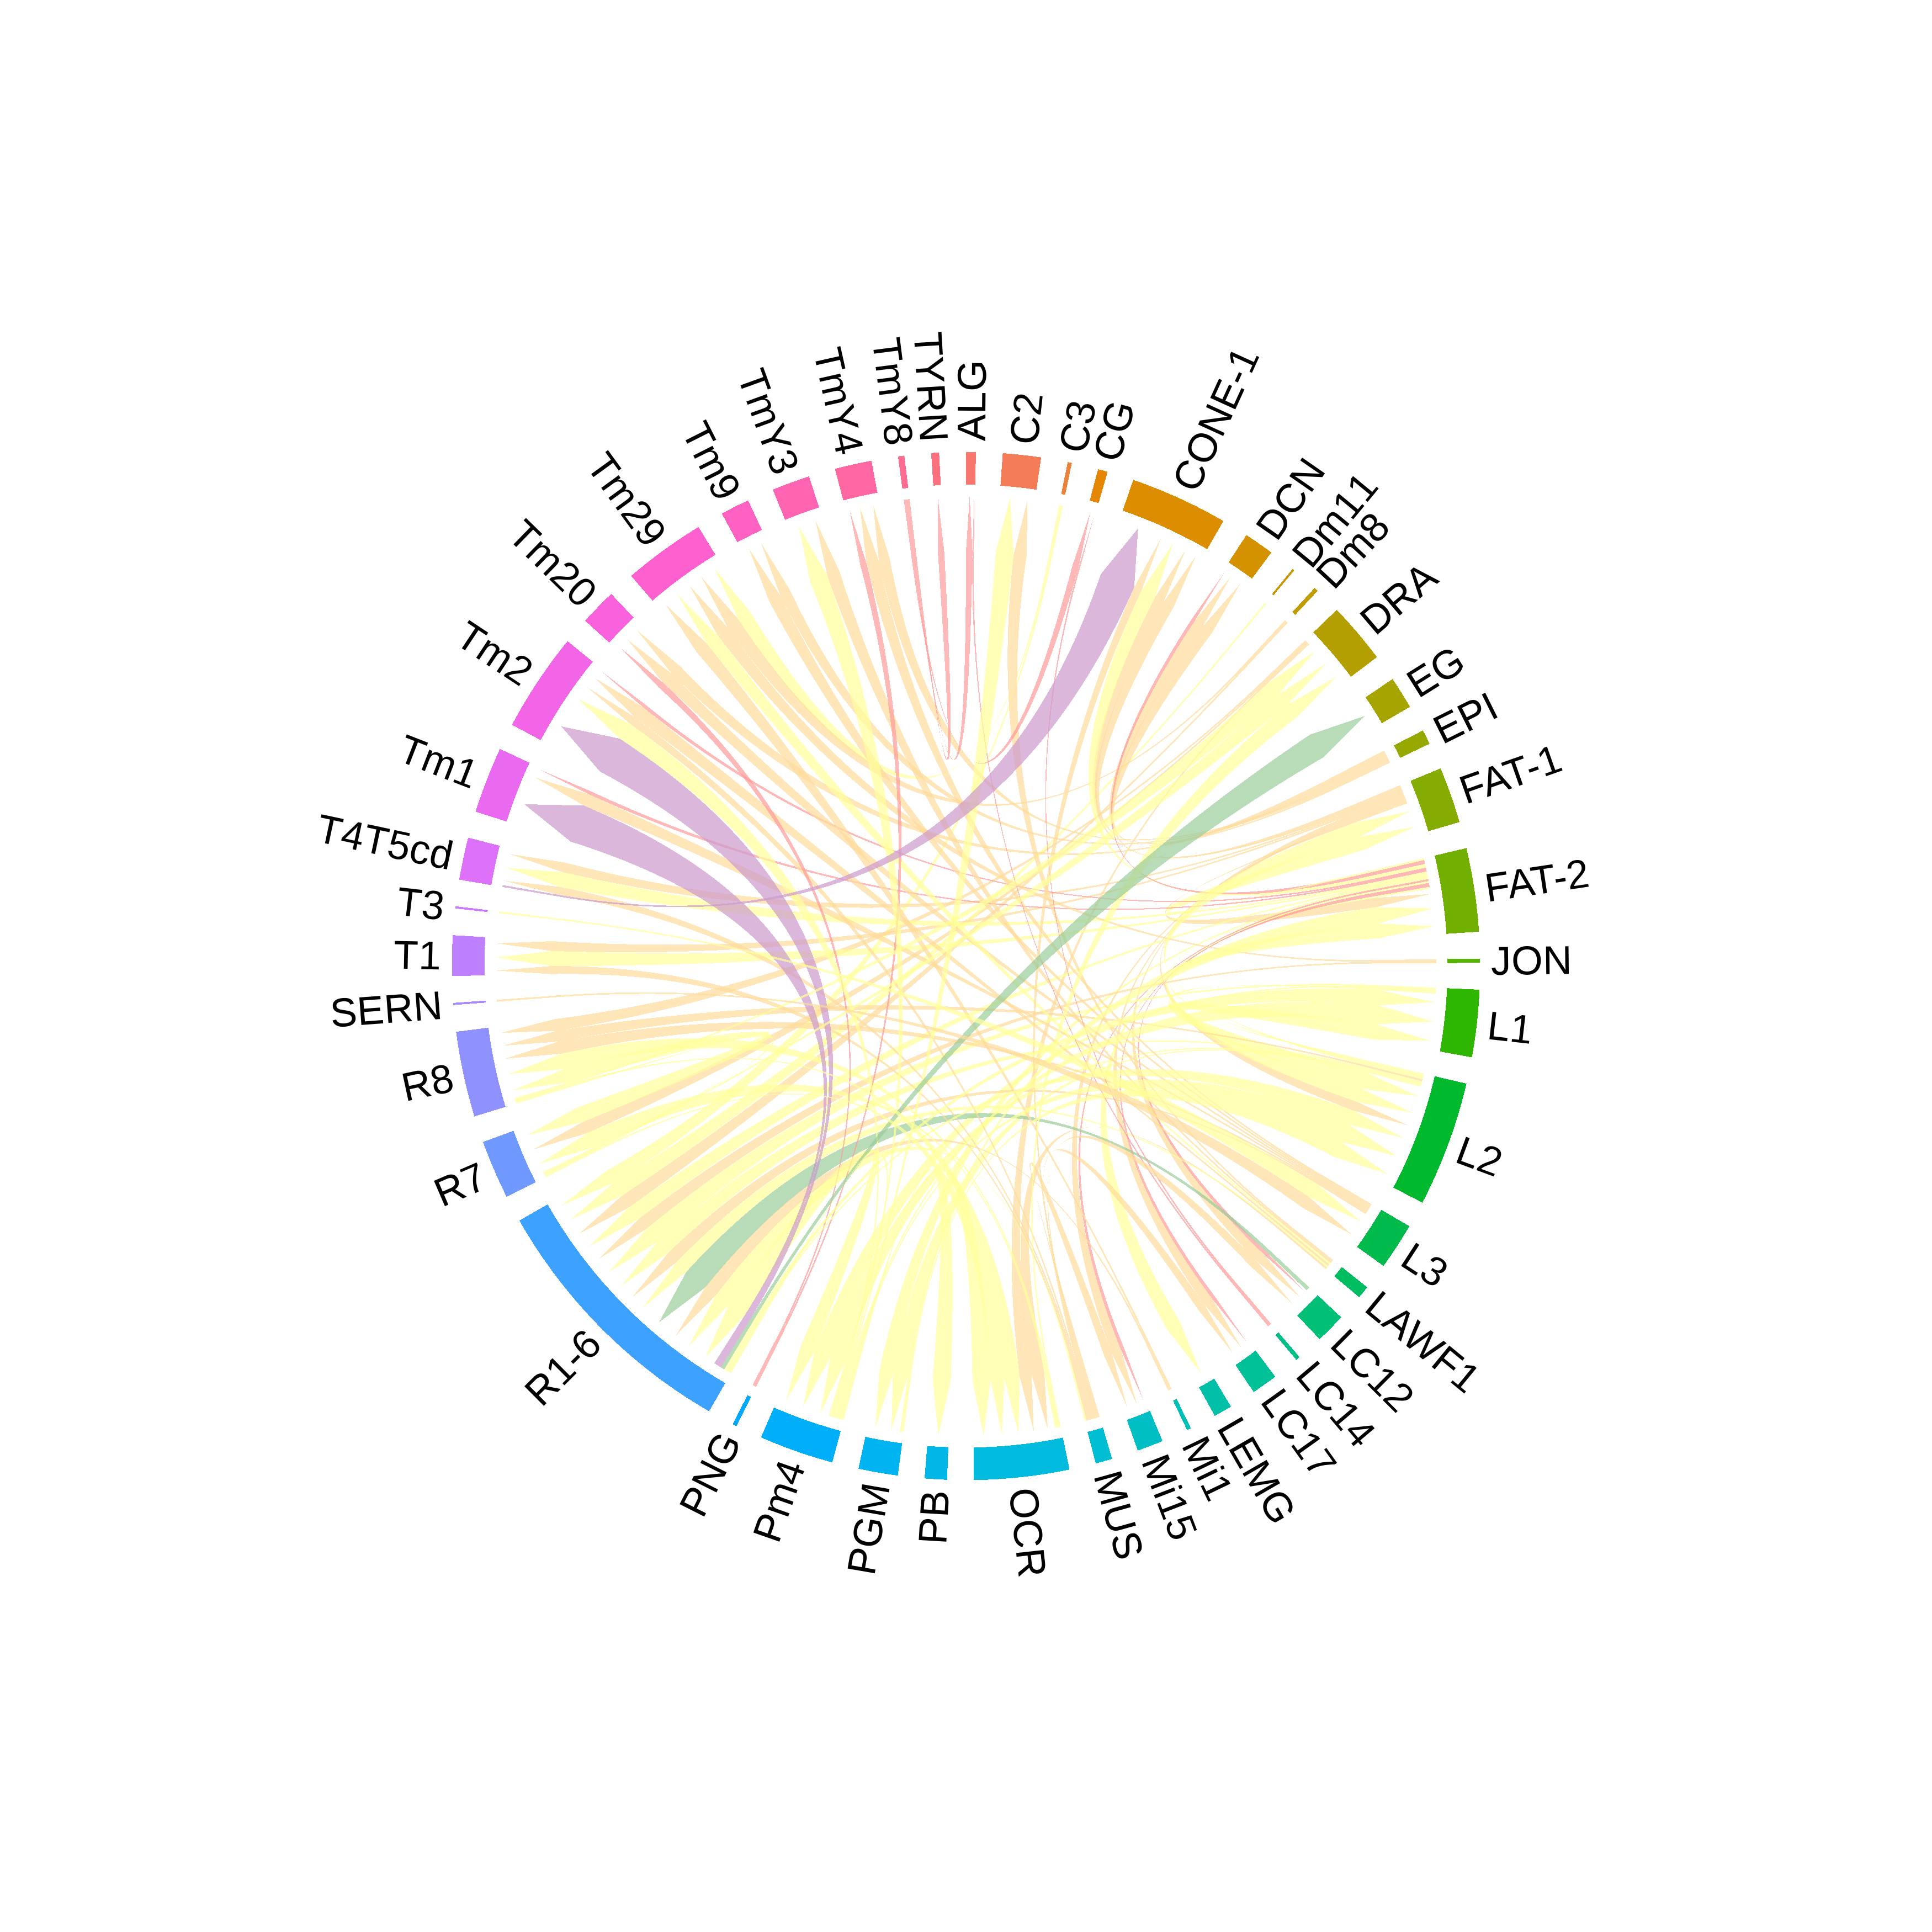

In [129]:
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)
library(stringr)

# Make background white
par(bg = "white")

#-----------------------------------------------------------
# 1. Read in your data for MTDD and FlyPhoneDB
MTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/MTLD_combined.csv")
FlyPhoneDB <- read_excel("FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx", skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from MTDD
MTLD <- MTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
ligand_df <- FlyPhoneDB %>% 
  inner_join(MTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(MTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}
combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)

#-----------------------------------------------------------
# 5. Aggregate interactions by cell type pairs
agg_df <- combined_df %>%
  group_by(ligand_cell_type, receptor_cell_type) %>%
  summarise(interaction_count = n(),
            avg_ligand_LAG = mean(ligand_LAG),
            .groups = "drop")

# Remove self-communication (only inter-cell interactions)
agg_df <- agg_df %>%
  filter(trimws(ligand_cell_type) != trimws(receptor_cell_type))

#-----------------------------------------------------------
# 6. Binning time and mapping chord colors
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4", "ZT4-8", "ZT8-12", "ZT12-16", "ZT16-20", "ZT20-24")
agg_df <- agg_df %>%
  mutate(time_bin = cut(
    avg_ligand_LAG,
    breaks = bin_breaks,
    labels = bin_labels,
    include.lowest = TRUE,
    right = FALSE
  ))

bin_colors <- c("#ff9999", "#ffdb99", "#ffff99", "#99cc99", "#9999ff", "#cc99cc")
names(bin_colors) <- bin_labels
agg_df$col <- bin_colors[agg_df$time_bin]

#-----------------------------------------------------------
# 7. Prepare data for chordDiagram:
df_chord <- agg_df %>%
  rename(from = ligand_cell_type,
         to   = receptor_cell_type,
         value = interaction_count)

# Apply alpha transparency (0.7) to chord colors.
df_chord$col <- alpha(df_chord$col, 0.7)

#-----------------------------------------------------------
# 8. Sort cell types alphabetically and assign a HUSL-like palette.
sector_names <- sort(union(df_chord$from, df_chord$to))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names

dynamic_gap <- 3

#-----------------------------------------------------------
# 11. Set circlize parameters using the computed dynamic_gap:
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)
par(cex = 1.1)  # reduce font size

#-----------------------------------------------------------
# 12. Draw the chord diagram with directional arrows:
chordDiagram(
  x = df_chord,
  order = names(sector_colors),  # Ensure order matches the names in grid.col.
  grid.col = sector_colors,      # HUSL-like palette for sectors.
  col = df_chord$col,            # Chord colors based on time bins.
  directional = 1,
  direction.type = c("arrows"),
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$value / max(df_chord$value, na.rm = TRUE) * 5,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.05)
)

#-----------------------------------------------------------
# 13. Add custom sector labels:
circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

#-----------------------------------------------------------
# 14. Add a legend for the time bin colors:
lgd_bins <- Legend(
  labels = bin_labels,
  legend_gp = gpar(fill = bin_colors),
  title = "Time Bins"
)
#draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.9, "npc"))


# MTDD

Note: 1 point is out of plotting region in sector 'CONE-1', track '2'.

Note: 1 point is out of plotting region in sector 'CONE-1', track '2'.

Note: 1 point is out of plotting region in sector 'DAN', track '2'.

Note: 1 point is out of plotting region in sector 'DAN', track '2'.

Note: 1 point is out of plotting region in sector 'DRA', track '2'.

Note: 1 point is out of plotting region in sector 'DRA', track '2'.

Note: 1 point is out of plotting region in sector 'EG', track '2'.

Note: 1 point is out of plotting region in sector 'EG', track '2'.

Note: 1 point is out of plotting region in sector 'FAT-1', track '2'.

Note: 1 point is out of plotting region in sector 'FAT-1', track '2'.

Note: 1 point is out of plotting region in sector 'Pm2', track '2'.

Note: 1 point is out of plotting region in sector 'Pm2', track '2'.

Note: 1 point is out of plotting region in sector 'R8', track '2'.

Note: 1 point is out of plotting region in sector 'R8', track '2'.

Note: 1 point is out of plot

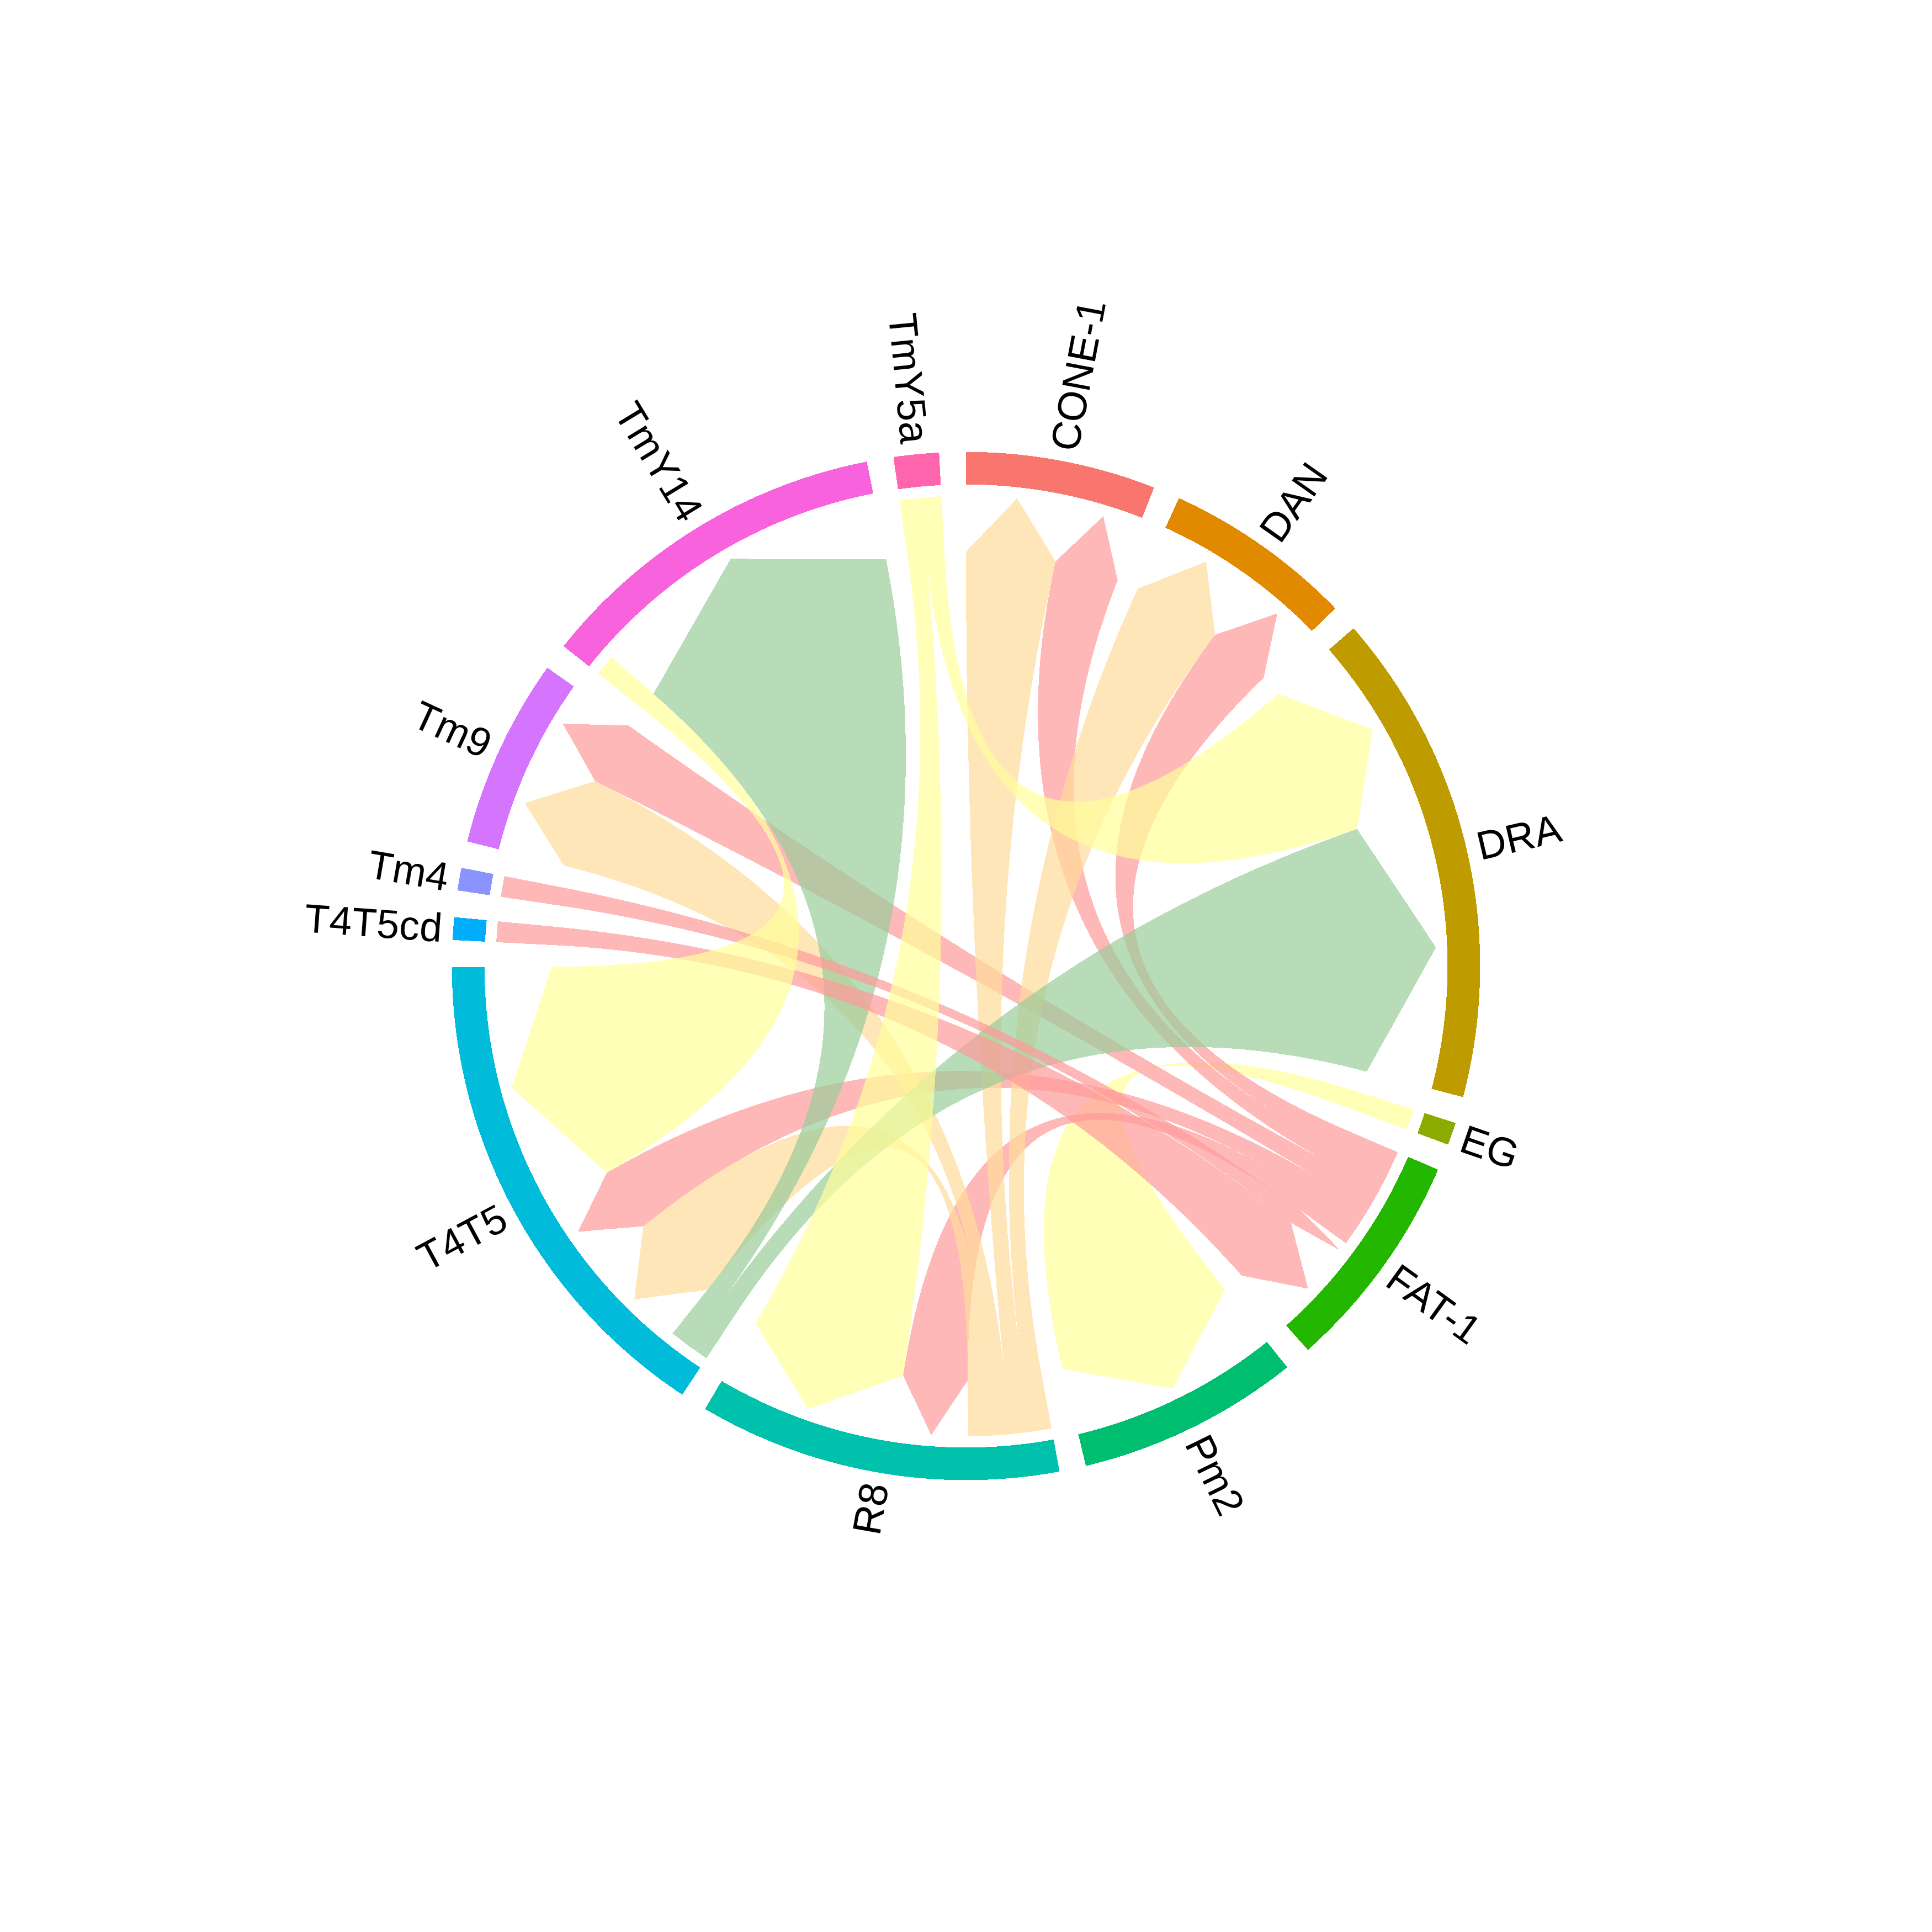

In [130]:
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)
library(stringr)

# Make background white
par(bg = "white")

#-----------------------------------------------------------
# 1. Read in your data
# For the peptidergic interactomic map, use the appropriate combined dataset.
# Change the file name as needed (e.g., "MTDD_combined.csv" for MTDD).
MTDD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/MTDD_combined.csv")
FlyPhoneDB <- read_excel("FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx", skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from the dataset.
MTDD <- MTDD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information.
ligand_df <- FlyPhoneDB %>% 
  inner_join(MTDD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(MTDD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)

#-----------------------------------------------------------
# 5. Aggregate interactions by cell type pairs
agg_df <- combined_df %>%
  group_by(ligand_cell_type, receptor_cell_type) %>%
  summarise(interaction_count = n(),
            avg_ligand_LAG = mean(ligand_LAG),
            .groups = "drop")

# Remove self-communication (only inter-cell interactions)
agg_df <- agg_df %>%
  filter(trimws(ligand_cell_type) != trimws(receptor_cell_type))

#-----------------------------------------------------------
# 6. Binning time and mapping chord colors
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4", "ZT4-8", "ZT8-12", "ZT12-16", "ZT16-20", "ZT20-24")

agg_df <- agg_df %>%
  mutate(time_bin = cut(
    avg_ligand_LAG,
    breaks = bin_breaks,
    labels = bin_labels,
    include.lowest = TRUE,
    right = FALSE
  ))

bin_colors <- c("#ff9999", "#ffdb99", "#ffff99", "#99cc99", "#9999ff", "#cc99cc")
names(bin_colors) <- bin_labels
agg_df$col <- bin_colors[agg_df$time_bin]

#-----------------------------------------------------------
# 7. Prepare data for chordDiagram:
df_chord <- agg_df %>%
  rename(from = ligand_cell_type,
         to   = receptor_cell_type,
         value = interaction_count)

# Apply alpha transparency (0.7) to chord colors.
df_chord$col <- alpha(df_chord$col, 0.7)

#-----------------------------------------------------------
# 8. Sort cell types alphabetically and assign a HUSL-like palette.
sector_names <- sort(union(df_chord$from, df_chord$to))
sector_colors <- hue_pal()(length(sector_names))
names(sector_colors) <- sector_names


dynamic_gap <- 3

#-----------------------------------------------------------
# 11. Set circlize parameters using the computed dynamic_gap:
circos.clear()
circos.par(
  start.degree = 90,
  gap.degree = dynamic_gap,
  message = FALSE,
  canvas.xlim = c(-1.5, 1.5),
  canvas.ylim = c(-1.5, 1.5)
)
par(cex = 1.1)  # reduce font size

#-----------------------------------------------------------
# 12. Draw the chord diagram with directional arrows:
chordDiagram(
  x = df_chord,
  order = names(sector_colors),  # Ensure order matches the names in grid.col.
  grid.col = sector_colors,      # HUSL-like palette for sectors.
  col = df_chord$col,            # Chord colors based on time bins.
  directional = 1,
  direction.type = c("arrows"),
  link.arr.type = "big.arrow",
  link.arr.length = 0.1,
  link.lwd = df_chord$value / max(df_chord$value, na.rm = TRUE) * 5,
  transparency = 0.2,
  annotationTrack = "grid",
  preAllocateTracks = list(track.height = 0.05)
)

#-----------------------------------------------------------
# 13. Add custom sector labels:
circos.trackPlotRegion(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    sector.index <- get.cell.meta.data("sector.index")
    circos.text(
      CELL_META$xcenter,
      CELL_META$ylim[1] - mm_y(-4),
      sector.index,
      facing = "clockwise",
      niceFacing = TRUE,
      adj = c(0, 0.5),
      col = "black",
      cex = 0.8
    )
  },
  bg.border = NA
)

#-----------------------------------------------------------
# 14. Add a legend for the time bin colors:
lgd_bins <- Legend(
  labels = bin_labels,
  legend_gp = gpar(fill = bin_colors),
  title = "Time Bins"
)
#draw(lgd_bins, x = unit(0.9, "npc"), y = unit(0.9, "npc"))


# Figure A-2

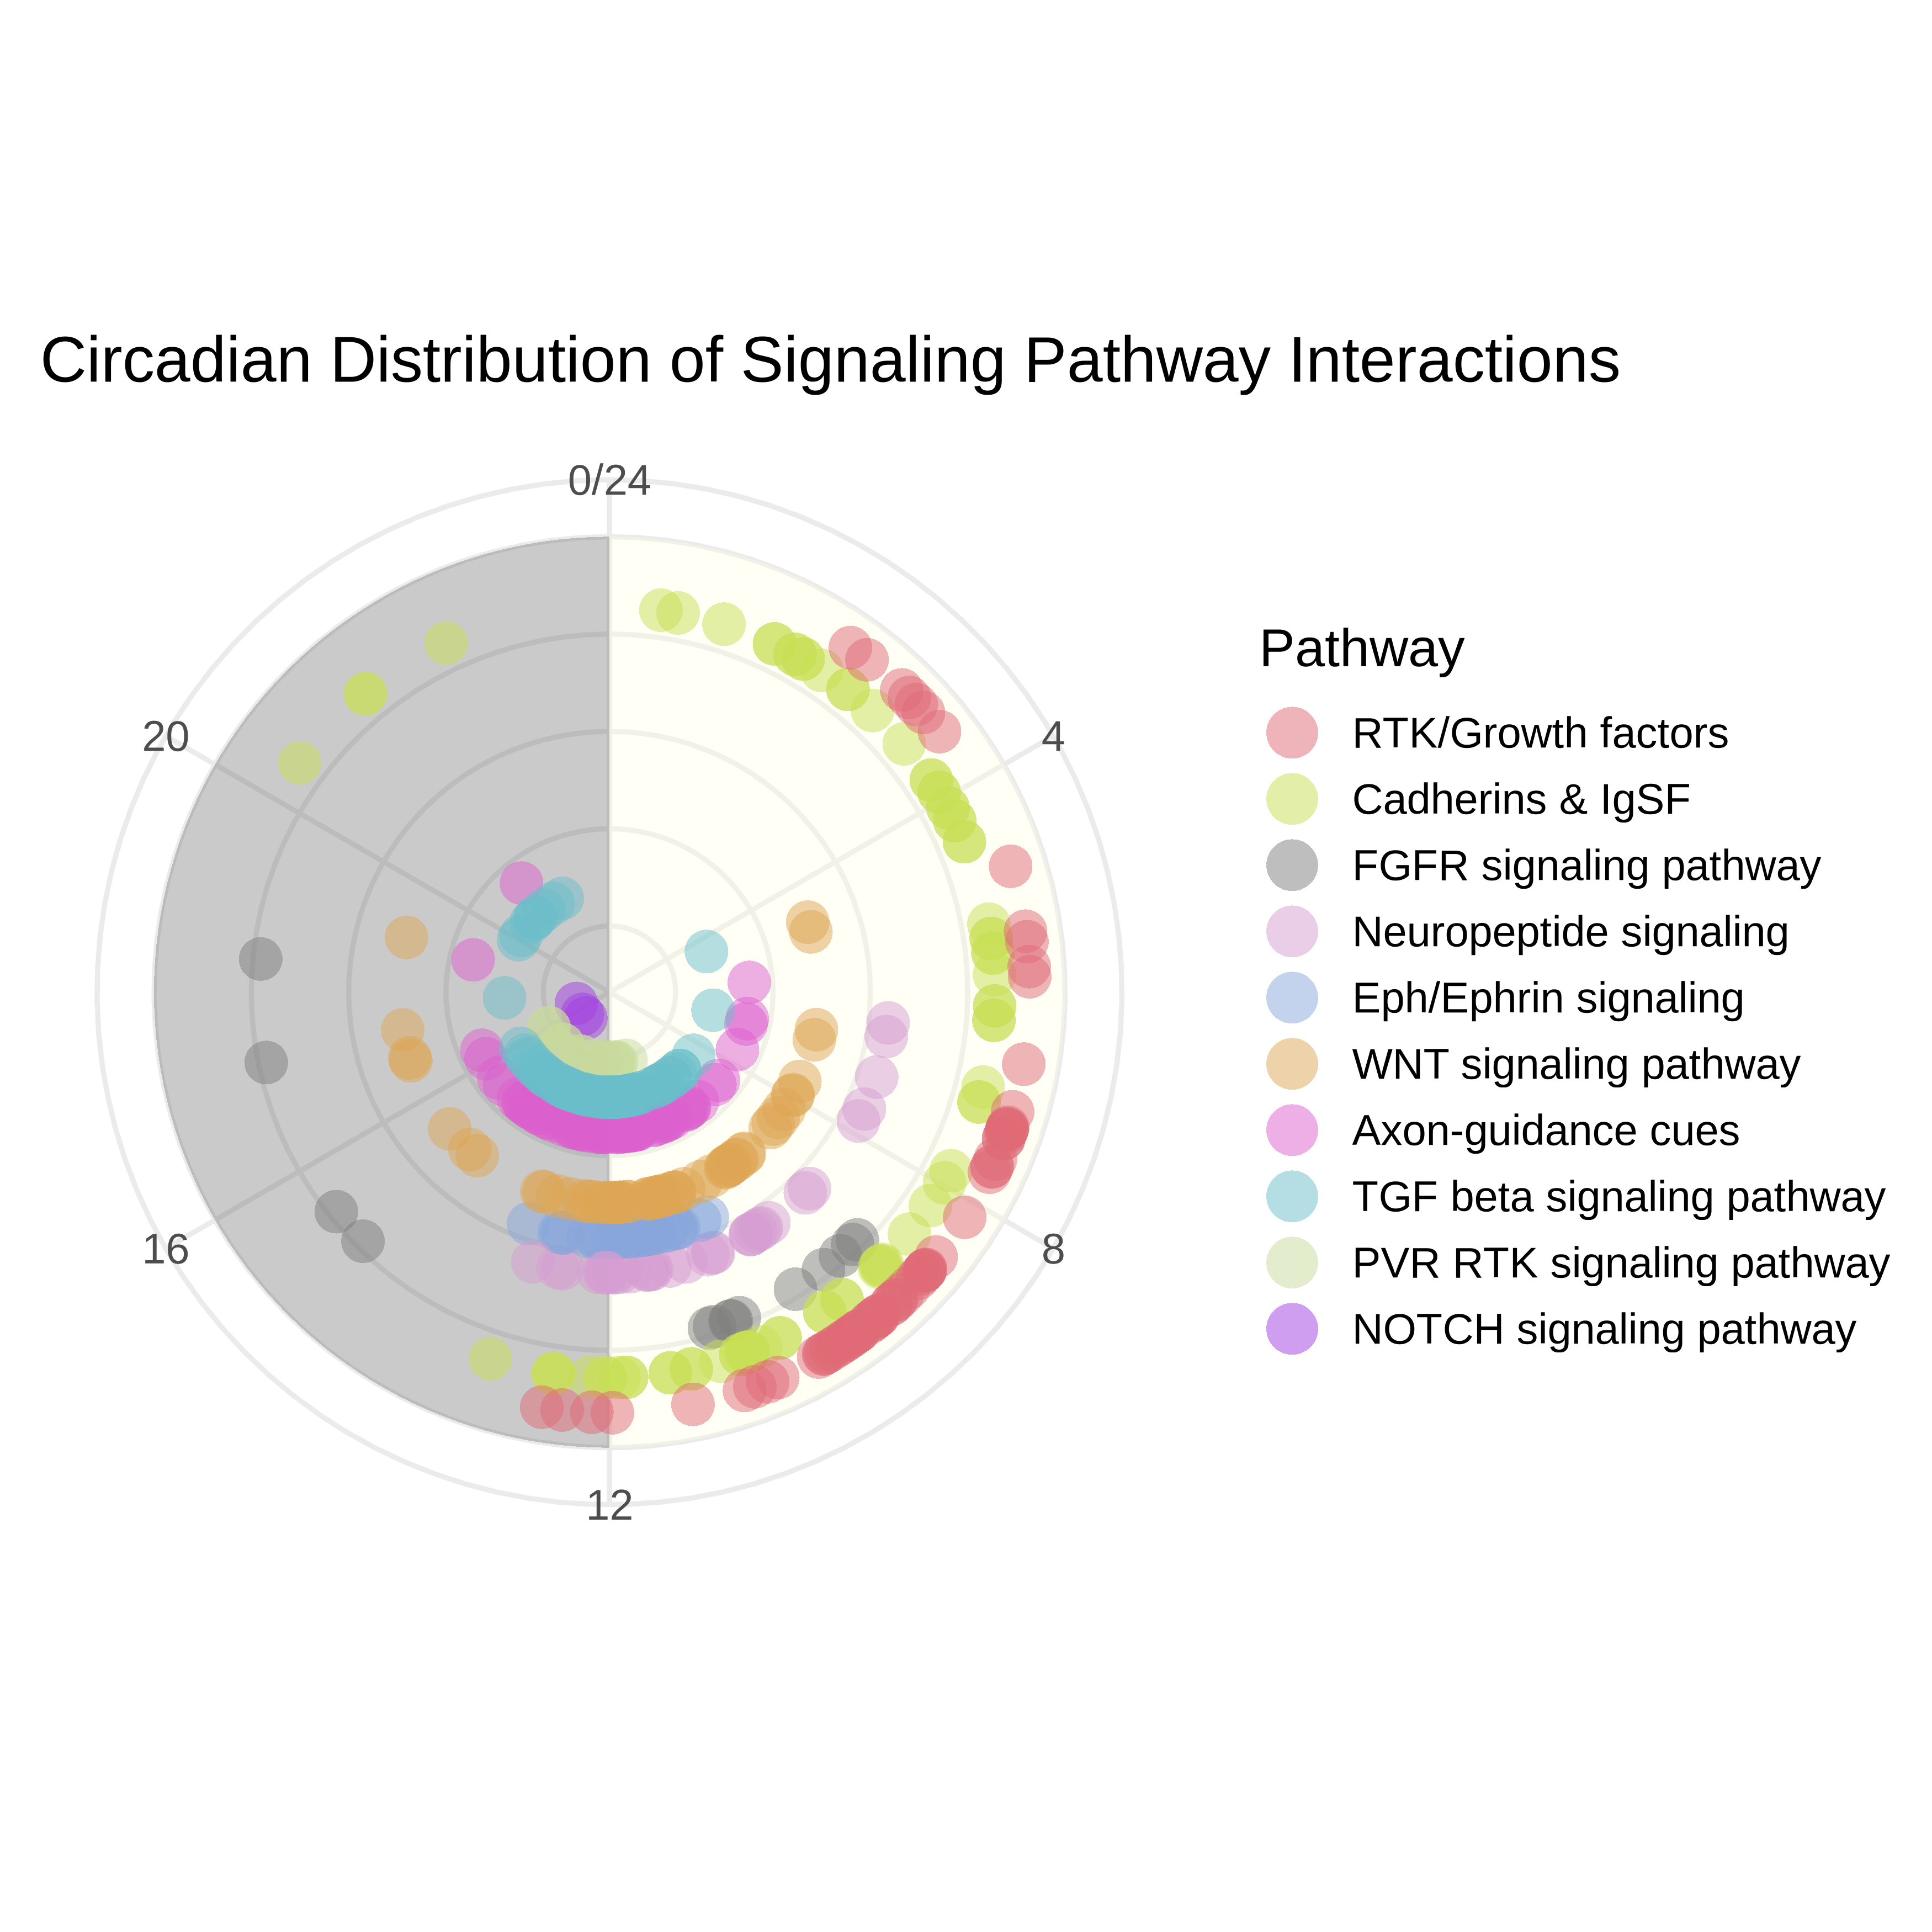

In [205]:
# Load required packages
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)

#-----------------------------------------------------------
# 1. Read in your data
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/WTLD_combined.csv")
FlyPhoneDB <- read_excel("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from WTLD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
# Use relationship = "many-to-many" to suppress warnings.
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand FBgn" = "FB_number"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor FBgn" = "FB_number"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
# Define a function to compute the minimal circadian difference (wrap-around)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)



combined_df <- combined_df %>% 
  # after your two inner_joins…
  rename(
    Signaling_Pathway = `Receptor Pathway`,
    ligand_FBGN        = `Ligand FBgn`,
    receptor_FBGN      = `Receptor FBgn`
  )
circadian_diff <- function(lag1, lag2) {
  d <- abs(lag1 - lag2)
  pmin(d, 24 - d)
}

combined_df <- combined_df %>%
  mutate(
    phase_diff = circadian_diff(ligand_LAG, receptor_LAG)
  ) %>%
  filter(phase_diff <= 4) %>%
  mutate(
    avg_lag = (ligand_LAG + receptor_LAG) / 2
    # or use your previous avg_ligand_LAG if you prefer
  )
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4","ZT4-8","ZT8-12","ZT12-16","ZT16-20","ZT20-24")
bin_colors <- c("yellow3","#707000","#505010","#707070","#404040","black")
names(bin_colors) <- bin_labels

combined_df <- combined_df %>%
  mutate(
    time_bin = cut(
      avg_lag, breaks = bin_breaks, labels = bin_labels,
      include.lowest = TRUE, right = FALSE
    ),
    bin_col = bin_colors[time_bin]
  )


library(dplyr)
library(ggplot2)
library(forcats)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Rename FlyPhoneDB pathway column if needed:
# ─────────────────────────────────────────────────────────────────────────────
# If your dataframe still uses the original FlyPhoneDB column name,
# uncomment and adjust the line below. Otherwise, assume you already
# have a column called Signaling_Pathway.
#
# combined_df <- combined_df %>%
#   rename(Signaling_Pathway = `Receptor Pathway`)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define your fixed “core” pathways (13 total, no Hedgehog)
# ─────────────────────────────────────────────────────────────────────────────
core_order <- c(
    "RTK/Growth factors",
    "Cadherins & IgSF",
    "FGFR signaling pathway",
    "INSULIN signaling pathway",
    "Neuropeptide signaling",
    "Eph/Ephrin signaling",
    "WNT signaling pathway",
    "EGFR signaling pathway",
    "Axon-guidance cues",
    "TGF beta signaling pathway",
    "PVR RTK signaling pathway",
    "NOTCH signaling pathway",
    "Toll signaling pathway"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) SCENIC‐style base palette — take the first 13 for your core pathways
# ─────────────────────────────────────────────────────────────────────────────
base_colors <- c(
  "#E06B77", "#C8E055", "#7E7E7E", "#6CE177", "#D69ED1",
  "#87A5DB", "#DDA555", "#836ED3", "#DC60CD", "#6ABEC9",
  "#C7DA9C", "#A13FE1", "#CFA79E", "#7AE2BF", "#5ABEF9",
  "#EA4E4E", "#286ED8"
)

core_colors  <- base_colors[seq_along(core_order)]
names(core_colors) <- core_order

# assign any other pathway a neutral grey
extras        <- setdiff(unique(combined_df$Signaling_Pathway), core_order)
extra_colors  <- setNames(rep("grey50", length(extras)), extras)

# combine into a single named palette
path_pal <- c(core_colors, extra_colors)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
inner_hole <- 5     # blank center radius
ring_width <- 1.8   # spacing between rings

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build the plotting dataframe:
#    (filter to core pathways, compute avg_lag → phase_deg, ring_id, radius)
# ─────────────────────────────────────────────────────────────────────────────
plot_df <- combined_df %>%
  filter(Signaling_Pathway %in% core_order) %>%
  mutate(
    avg_lag        = (ligand_LAG + receptor_LAG) / 2,
    phase_deg      = 360 * (avg_lag / 24),
    pathway_factor = factor(Signaling_Pathway, levels = core_order),
    ring_id        = as.numeric(pathway_factor),
    radius         = inner_hole + ring_id * ring_width
  )

max_r <- max(plot_df$radius, na.rm = TRUE) + ring_width

# ─────────────────────────────────────────────────────────────────────────────
# 6) Draw the SCENIC‐style donut plot
# ─────────────────────────────────────────────────────────────────────────────
ggplot(plot_df, aes(x = phase_deg, y = radius, color = pathway_factor)) +
  # day/night background
  #annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
  #         fill = "gray80", alpha = 0.3) +
  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin = 180, xmax = 360, ymin = -Inf, ymax = Inf,
           fill = "gray30", alpha = 0.3) +

  # big solid circles
  geom_point(
    shape    = 16,
    size     = 5,
    alpha    = 0.5,
    position = position_jitter(height = 0.0)
  ) +
  # polar coordinates
  coord_polar(theta = "x", start = 0, clip = "off") +
  # 0–24 h angular axis
  scale_x_continuous(
    limits = c(0, 360),
    breaks = seq(0, 360, by = 60),
    labels = seq(0, 24, by = 4)
  ) +
  # reverse radial axis, clamp to leave donut hole
  scale_y_reverse(
    limits = c(max_r, inner_hole),
    expand = c(0, 0)
  ) +
  # fixed color mapping for pathways
  scale_color_manual(
    name   = "Pathway",
    values = path_pal,
    guide  = guide_legend(override.aes = list(size = 6))
  ) +
  # clean theme
  theme_minimal(base_size = 14) +
  theme(
    axis.title       = element_blank(),
    axis.text.y      = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position  = "right"
  ) +
  labs(
    title = "Circadian Distribution of Signaling Pathway Interactions"
  )


In [150]:
unique(combined_df$Signaling_Pathway)

[1] "FGFR signaling pathway"      "HEDGEHOG signaling pathway" 
 [3] "HIPPO signaling pathway"     "NOTCH signaling pathway"    
 [5] "Neuropeptide signaling"      "Eph/Ephrin signaling"       
 [7] "Axon-guidance cues"          "WNT signaling pathway"      
 [9] "Cadherins & IgSF"            "RTK/Growth factors"         
[11] "PVR RTK signaling pathway"   "TGF beta signaling pathway" 
[13] "TNF alpha signaling pathway"

In [50]:
# Filter for "Neuropeptide signaling" pathway
neuropep_df <- combined_df %>%
  filter(Signaling_Pathway == "Neuropeptide signaling") %>%
  select(ligand_cell_type, receptor_cell_type,
         ligand_FBGN = `ligand_FBGN`, Ligand_Symbol = `Ligand Gene Symbol`,
         receptor_FBGN = `receptor_FBGN`, Receptor_Symbol = `Receptor Gene Symbol`,
         ligand_LAG, receptor_LAG, phase_diff)

# View distinct ligand/receptor cell types
unique_ligand_cell_types <- unique(neuropep_df$ligand_cell_type)
unique_receptor_cell_types <- unique(neuropep_df$receptor_cell_type)

# View distinct genes
unique_ligand_genes <- unique(neuropep_df$Ligand_Symbol)
unique_receptor_genes <- unique(neuropep_df$Receptor_Symbol)

# Optionally: save or view a summary table
neuropep_summary <- neuropep_df %>%
  count(ligand_cell_type, receptor_cell_type, Ligand_Symbol, Receptor_Symbol, sort = TRUE)

# To view
print(neuropep_summary)


# A tibble: 15 × 5
   ligand_cell_type receptor_cell_type Ligand_Symbol Receptor_Symbol     n
   <chr>            <chr>              <chr>         <chr>           <int>
 1 ALG              JON                fog           mthl1               1
 2 ALG              L3                 fog           mthl1               1
 3 ALG              Mi1                fog           mthl1               1
 4 HE               KCy                Tk            TkR86C              1
 5 KCy              KCy                sNPF          sNPF-R              1
 6 KCy              R1-6               sNPF          sNPF-R              1
 7 KCy              T3                 sNPF          sNPF-R              1
 8 Mi15             KCy                sNPF          sNPF-R              1
 9 Mi15             R1-6               sNPF          sNPF-R              1
10 Mi15             T3                 sNPF          sNPF-R              1
11 PGM              JON                fog           mthl1               1
12 PGM

# WTLD

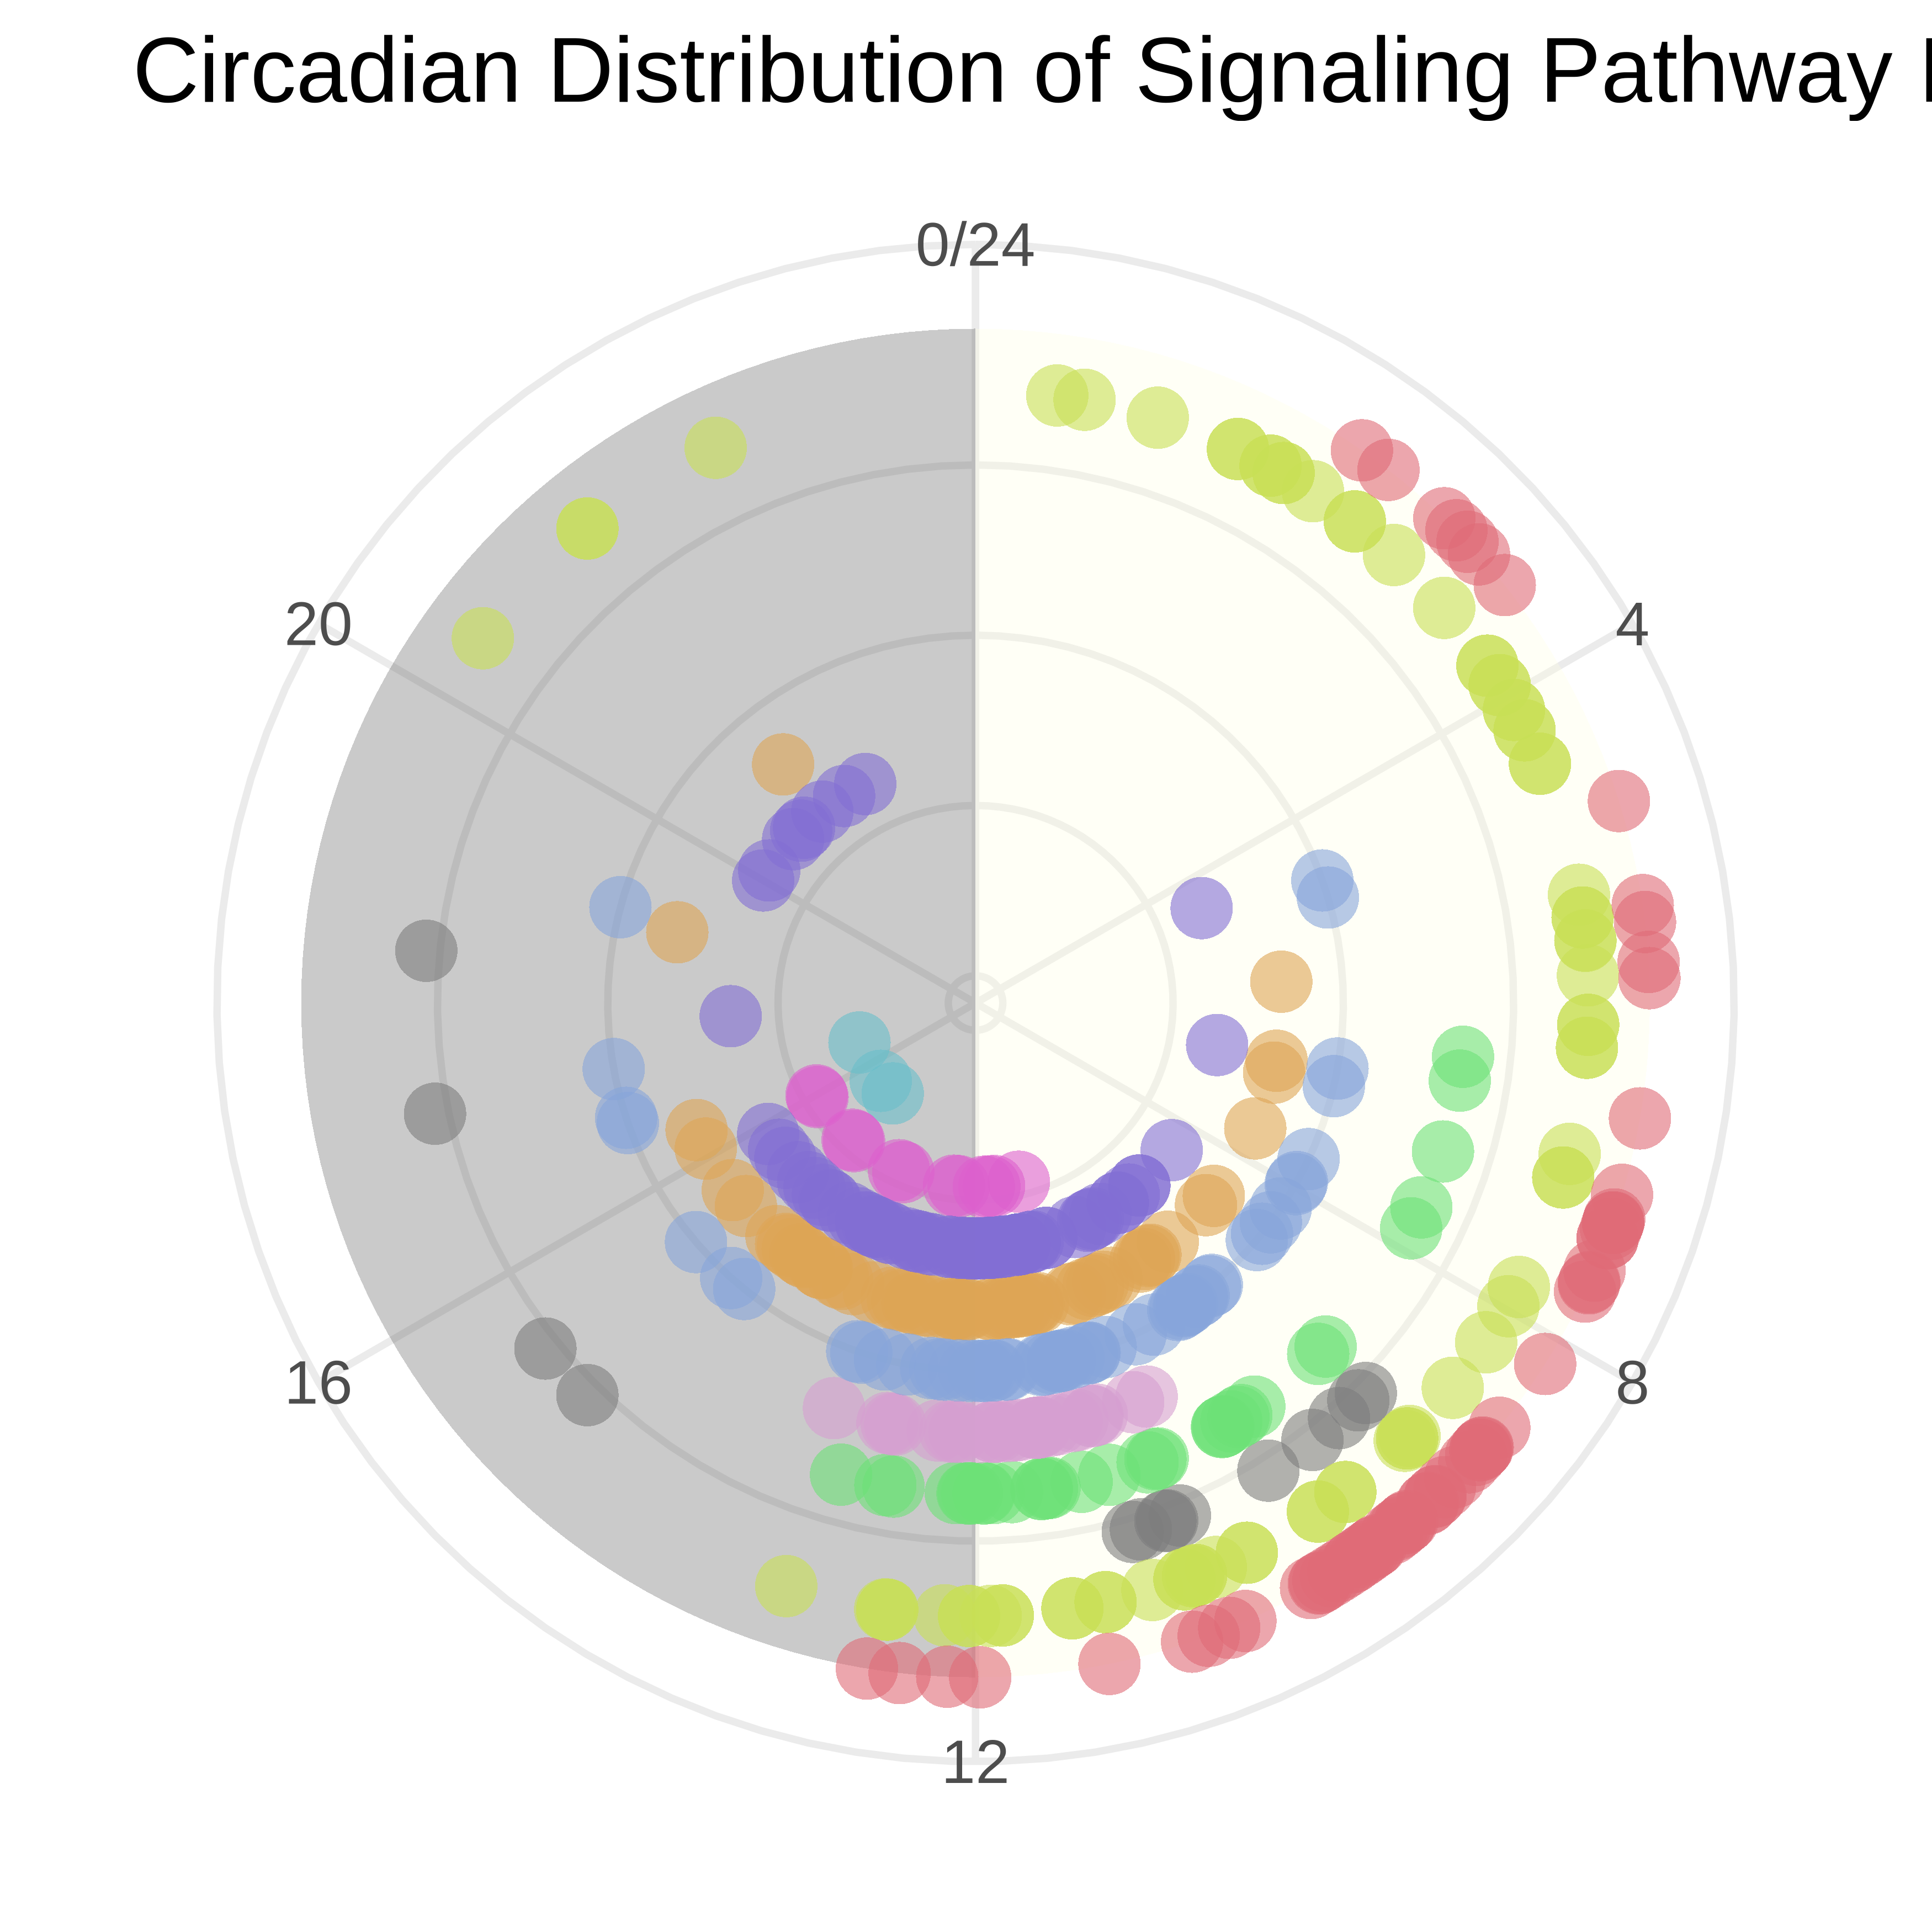

In [196]:
# Load required packages
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)

#-----------------------------------------------------------
# 1. Read in your data
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/WTLD_combined.csv")
FlyPhoneDB <- read_excel("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from WTLD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
# Use relationship = "many-to-many" to suppress warnings.
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
# Define a function to compute the minimal circadian difference (wrap-around)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)



combined_df <- combined_df %>% 
  # after your two inner_joins…
  rename(
    Signaling_Pathway = `Receptor Pathway`,
    ligand_FBGN        = `Ligand FBgn`,
    receptor_FBGN      = `Receptor FBgn`
  )
circadian_diff <- function(lag1, lag2) {
  d <- abs(lag1 - lag2)
  pmin(d, 24 - d)
}

combined_df <- combined_df %>%
  mutate(
    phase_diff = circadian_diff(ligand_LAG, receptor_LAG)
  ) %>%
  filter(phase_diff <= 4) %>%
  mutate(
    avg_lag = (ligand_LAG + receptor_LAG) / 2
    # or use your previous avg_ligand_LAG if you prefer
  )
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4","ZT4-8","ZT8-12","ZT12-16","ZT16-20","ZT20-24")
bin_colors <- c("yellow3","#707000","#505010","#707070","#404040","black")
names(bin_colors) <- bin_labels

combined_df <- combined_df %>%
  mutate(
    time_bin = cut(
      avg_lag, breaks = bin_breaks, labels = bin_labels,
      include.lowest = TRUE, right = FALSE
    ),
    bin_col = bin_colors[time_bin]
  )
library(dplyr)
library(ggplot2)
library(forcats)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Rename FlyPhoneDB pathway column if needed:
# ─────────────────────────────────────────────────────────────────────────────
# combined_df <- combined_df %>%
#   rename(Signaling_Pathway = `Receptor Pathway`)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define your fixed “core” pathways (13 total, no Hedgehog)
# ─────────────────────────────────────────────────────────────────────────────
core_order <- c(
    "RTK/Growth factors",
    "Cadherins & IgSF",
    "FGFR signaling pathway",
    #"INSULIN signaling pathway",
    "Neuropeptide signaling",
    "Eph/Ephrin signaling",
    "WNT signaling pathway",
    #"EGFR signaling pathway",
    "Axon-guidance cues",
    "TGF beta signaling pathway",
    "PVR RTK signaling pathway",
    "NOTCH signaling pathway",
    "Toll signaling pathway"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) SCENIC‐style base palette — take the first 13 for your core pathways
# ─────────────────────────────────────────────────────────────────────────────
base_colors <- c(
  "#E06B77", "#C8E055", "#7E7E7E", "#6CE177", "#D69ED1",
  "#87A5DB", "#DDA555", "#836ED3", "#DC60CD", "#6ABEC9",
  "#C7DA9C", "#A13FE1", "#CFA79E", "#7AE2BF", "#5ABEF9",
  "#EA4E4E", "#286ED8"
)
core_colors <- setNames(base_colors[seq_along(core_order)], core_order)
extras      <- setdiff(unique(combined_df$Signaling_Pathway), core_order)
extra_colors<- setNames(rep("grey50", length(extras)), extras)
path_pal    <- c(core_colors, extra_colors)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
inner_hole <- 6     # blank center radius
ring_width <- 1.8   # spacing between rings

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build the plotting dataframe
# ─────────────────────────────────────────────────────────────────────────────
plot_df <- combined_df %>%
  filter(Signaling_Pathway %in% core_order) %>%
  mutate(
    avg_lag        = (ligand_LAG + receptor_LAG) / 2,
    phase_deg      = 360 * (avg_lag / 24),
    pathway_factor = factor(Signaling_Pathway, levels = core_order),
    ring_id        = as.numeric(pathway_factor),
    # ◀◀ ZERO-BASED radius: first ring sits at inner_hole
    radius         = inner_hole + (ring_id - 1) * ring_width
  )

# ◀◀ Recompute max_r so the outer edge matches the new zero-based radius
max_r <- inner_hole + (length(core_order)) * ring_width

# ─────────────────────────────────────────────────────────────────────────────
# 6) Draw the SCENIC‐style donut plot
# ─────────────────────────────────────────────────────────────────────────────
ggplot(plot_df, aes(x = phase_deg, y = radius, color = pathway_factor)) +
  # day/night background
#  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
#           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin = 180, xmax = 360, ymin = -Inf, ymax = Inf,
           fill = "gray30", alpha = 0.3) +

  # big solid circles
  geom_point(
    shape    = 16,
    size     = 7.3,
    alpha    = 0.6,
    position = position_jitter(height = 0.0)
  ) +
  # polar coordinates
  coord_polar(theta = "x", start = 0, clip = "off") +
  # 0–24 h angular axis
  scale_x_continuous(
    limits = c(0, 360),
    breaks = seq(0, 360, by = 60),
    labels = seq(0, 24, by = 4)
  ) +
  # reverse radial axis: carve out a hole [0..inner_hole]
  scale_y_reverse(
    limits = c(max_r, inner_hole),
    expand = c(0, 0)
  ) +
  # fixed color mapping for pathways
  scale_color_manual(
    name   = "Pathway",
    values = path_pal,
    guide  = guide_legend(override.aes = list(size = 6))
  ) +
  # clean theme
  theme_minimal(base_size = 20) +
  theme(
    axis.title       = element_blank(),
    axis.text.y      = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position  = "none"
  ) +
  labs(
    title = "Circadian Distribution of Signaling Pathway Interactions"
  )


# WTDD

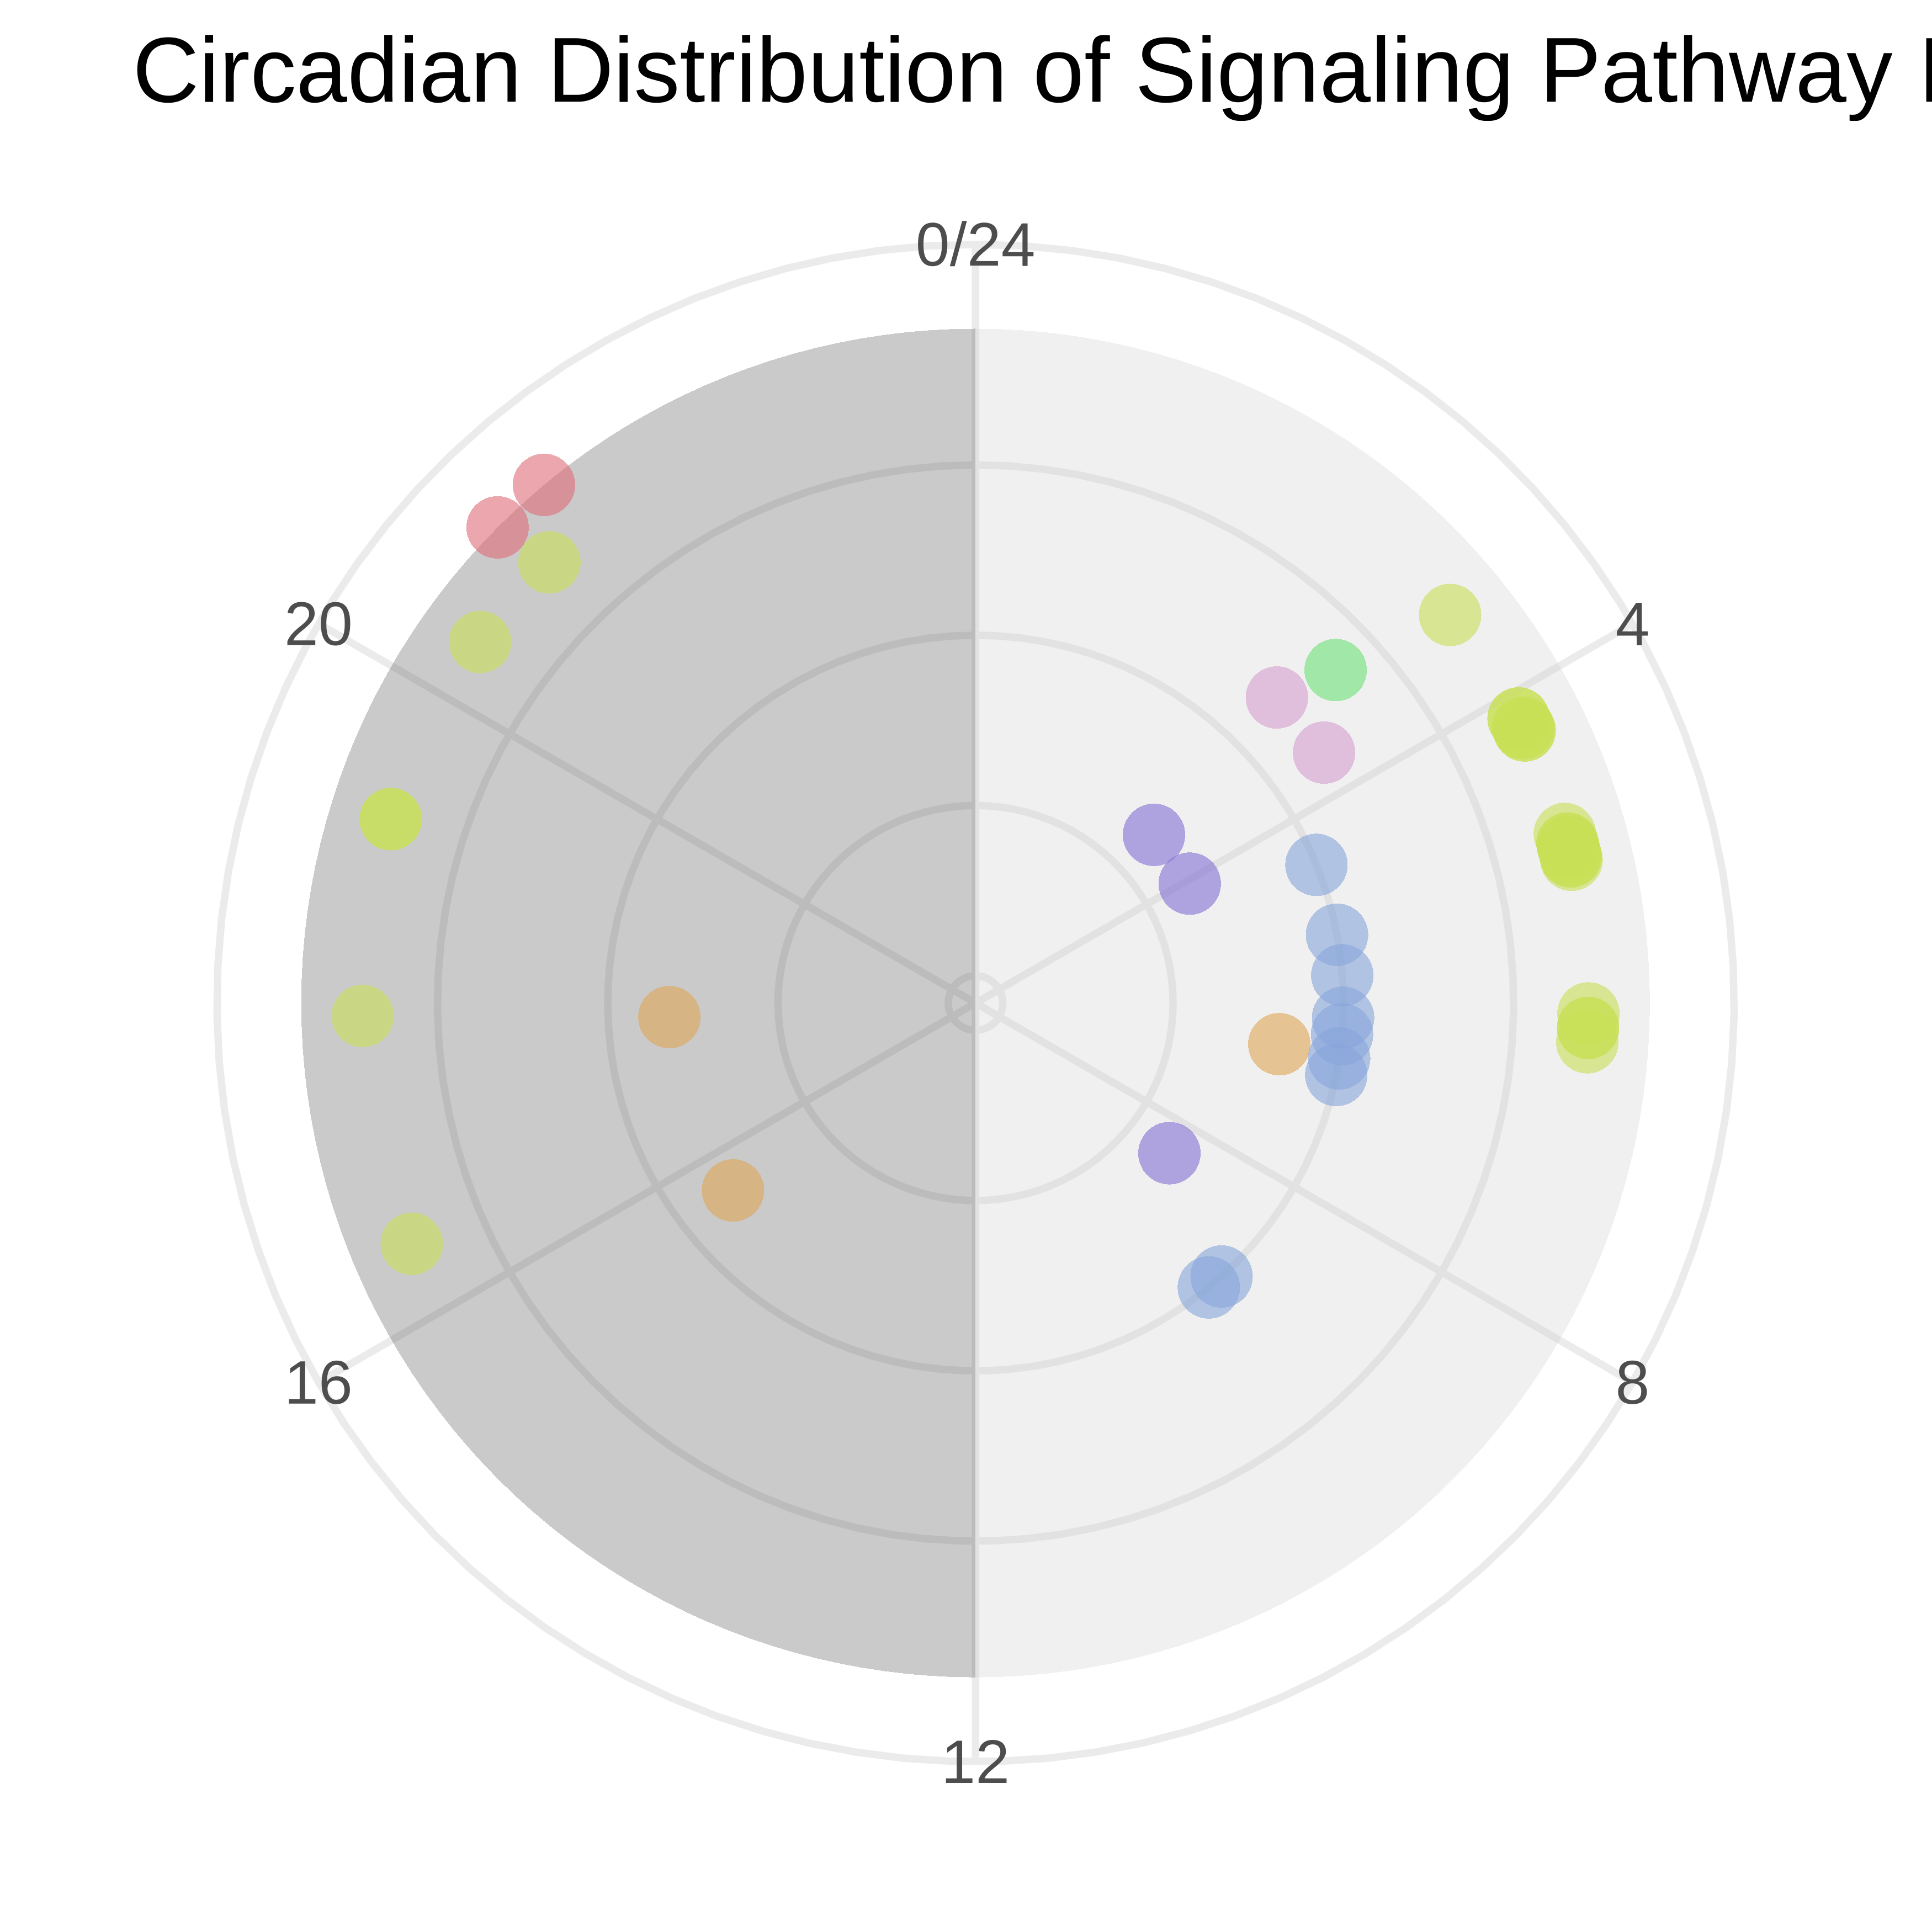

In [197]:
# Load required packages
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)

#-----------------------------------------------------------
# 1. Read in your data
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/WTDD_combined.csv")
FlyPhoneDB <- read_excel("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from WTLD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
# Use relationship = "many-to-many" to suppress warnings.
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
# Define a function to compute the minimal circadian difference (wrap-around)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)



combined_df <- combined_df %>% 
  # after your two inner_joins…
  rename(
    Signaling_Pathway = `Receptor Pathway`,
    ligand_FBGN        = `Ligand FBgn`,
    receptor_FBGN      = `Receptor FBgn`
  )
circadian_diff <- function(lag1, lag2) {
  d <- abs(lag1 - lag2)
  pmin(d, 24 - d)
}

combined_df <- combined_df %>%
  mutate(
    phase_diff = circadian_diff(ligand_LAG, receptor_LAG)
  ) %>%
  filter(phase_diff <= 4) %>%
  mutate(
    avg_lag = (ligand_LAG + receptor_LAG) / 2
    # or use your previous avg_ligand_LAG if you prefer
  )
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4","ZT4-8","ZT8-12","ZT12-16","ZT16-20","ZT20-24")
bin_colors <- c("yellow3","#707000","#505010","#707070","#404040","black")
names(bin_colors) <- bin_labels

combined_df <- combined_df %>%
  mutate(
    time_bin = cut(
      avg_lag, breaks = bin_breaks, labels = bin_labels,
      include.lowest = TRUE, right = FALSE
    ),
    bin_col = bin_colors[time_bin]
  )
library(dplyr)
library(ggplot2)
library(forcats)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Rename FlyPhoneDB pathway column if needed:
# ─────────────────────────────────────────────────────────────────────────────
# combined_df <- combined_df %>%
#   rename(Signaling_Pathway = `Receptor Pathway`)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define your fixed “core” pathways (13 total, no Hedgehog)
# ─────────────────────────────────────────────────────────────────────────────
core_order <- c(
    "RTK/Growth factors",
    "Cadherins & IgSF",
    "FGFR signaling pathway",
    #"INSULIN signaling pathway",
    "Neuropeptide signaling",
    "Eph/Ephrin signaling",
    "WNT signaling pathway",
    #"EGFR signaling pathway",
    "Axon-guidance cues",
    "TGF beta signaling pathway",
    "PVR RTK signaling pathway",
    "NOTCH signaling pathway",
    "Toll signaling pathway"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) SCENIC‐style base palette — take the first 13 for your core pathways
# ─────────────────────────────────────────────────────────────────────────────
base_colors <- c(
  "#E06B77", "#C8E055", "#7E7E7E", "#6CE177", "#D69ED1",
  "#87A5DB", "#DDA555", "#836ED3", "#DC60CD", "#6ABEC9",
  "#C7DA9C", "#A13FE1", "#CFA79E", "#7AE2BF", "#5ABEF9",
  "#EA4E4E", "#286ED8"
)
core_colors <- setNames(base_colors[seq_along(core_order)], core_order)
extras      <- setdiff(unique(combined_df$Signaling_Pathway), core_order)
extra_colors<- setNames(rep("grey50", length(extras)), extras)
path_pal    <- c(core_colors, extra_colors)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
inner_hole <- 6     # blank center radius
ring_width <- 1.8   # spacing between rings

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build the plotting dataframe
# ─────────────────────────────────────────────────────────────────────────────
plot_df <- combined_df %>%
  filter(Signaling_Pathway %in% core_order) %>%
  mutate(
    avg_lag        = (ligand_LAG + receptor_LAG) / 2,
    phase_deg      = 360 * (avg_lag / 24),
    pathway_factor = factor(Signaling_Pathway, levels = core_order),
    ring_id        = as.numeric(pathway_factor),
    # ◀◀ ZERO-BASED radius: first ring sits at inner_hole
    radius         = inner_hole + (ring_id - 1) * ring_width
  )

# ◀◀ Recompute max_r so the outer edge matches the new zero-based radius
max_r <- inner_hole + (length(core_order)) * ring_width

# ─────────────────────────────────────────────────────────────────────────────
# 6) Draw the SCENIC‐style donut plot
# ─────────────────────────────────────────────────────────────────────────────
ggplot(plot_df, aes(x = phase_deg, y = radius, color = pathway_factor)) +
  # day/night background
#  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
#           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
           fill = "gray80", alpha = 0.3) +
  annotate("rect", xmin = 180, xmax = 360, ymin = -Inf, ymax = Inf,
           fill = "gray30", alpha = 0.3) +

  # big solid circles
  geom_point(
    shape    = 16,
    size     = 7.3,
    alpha    = 0.6,
    position = position_jitter(height = 0.0)
  ) +
  # polar coordinates
  coord_polar(theta = "x", start = 0, clip = "off") +
  # 0–24 h angular axis
  scale_x_continuous(
    limits = c(0, 360),
    breaks = seq(0, 360, by = 60),
    labels = seq(0, 24, by = 4)
  ) +
  # reverse radial axis: carve out a hole [0..inner_hole]
  scale_y_reverse(
    limits = c(max_r, inner_hole),
    expand = c(0, 0)
  ) +
  # fixed color mapping for pathways
  scale_color_manual(
    name   = "Pathway",
    values = path_pal,
    guide  = guide_legend(override.aes = list(size = 6))
  ) +
  # clean theme
  theme_minimal(base_size = 20) +
  theme(
    axis.title       = element_blank(),
    axis.text.y      = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position  = "none"
  ) +
  labs(
    title = "Circadian Distribution of Signaling Pathway Interactions"
  )


# MTLD

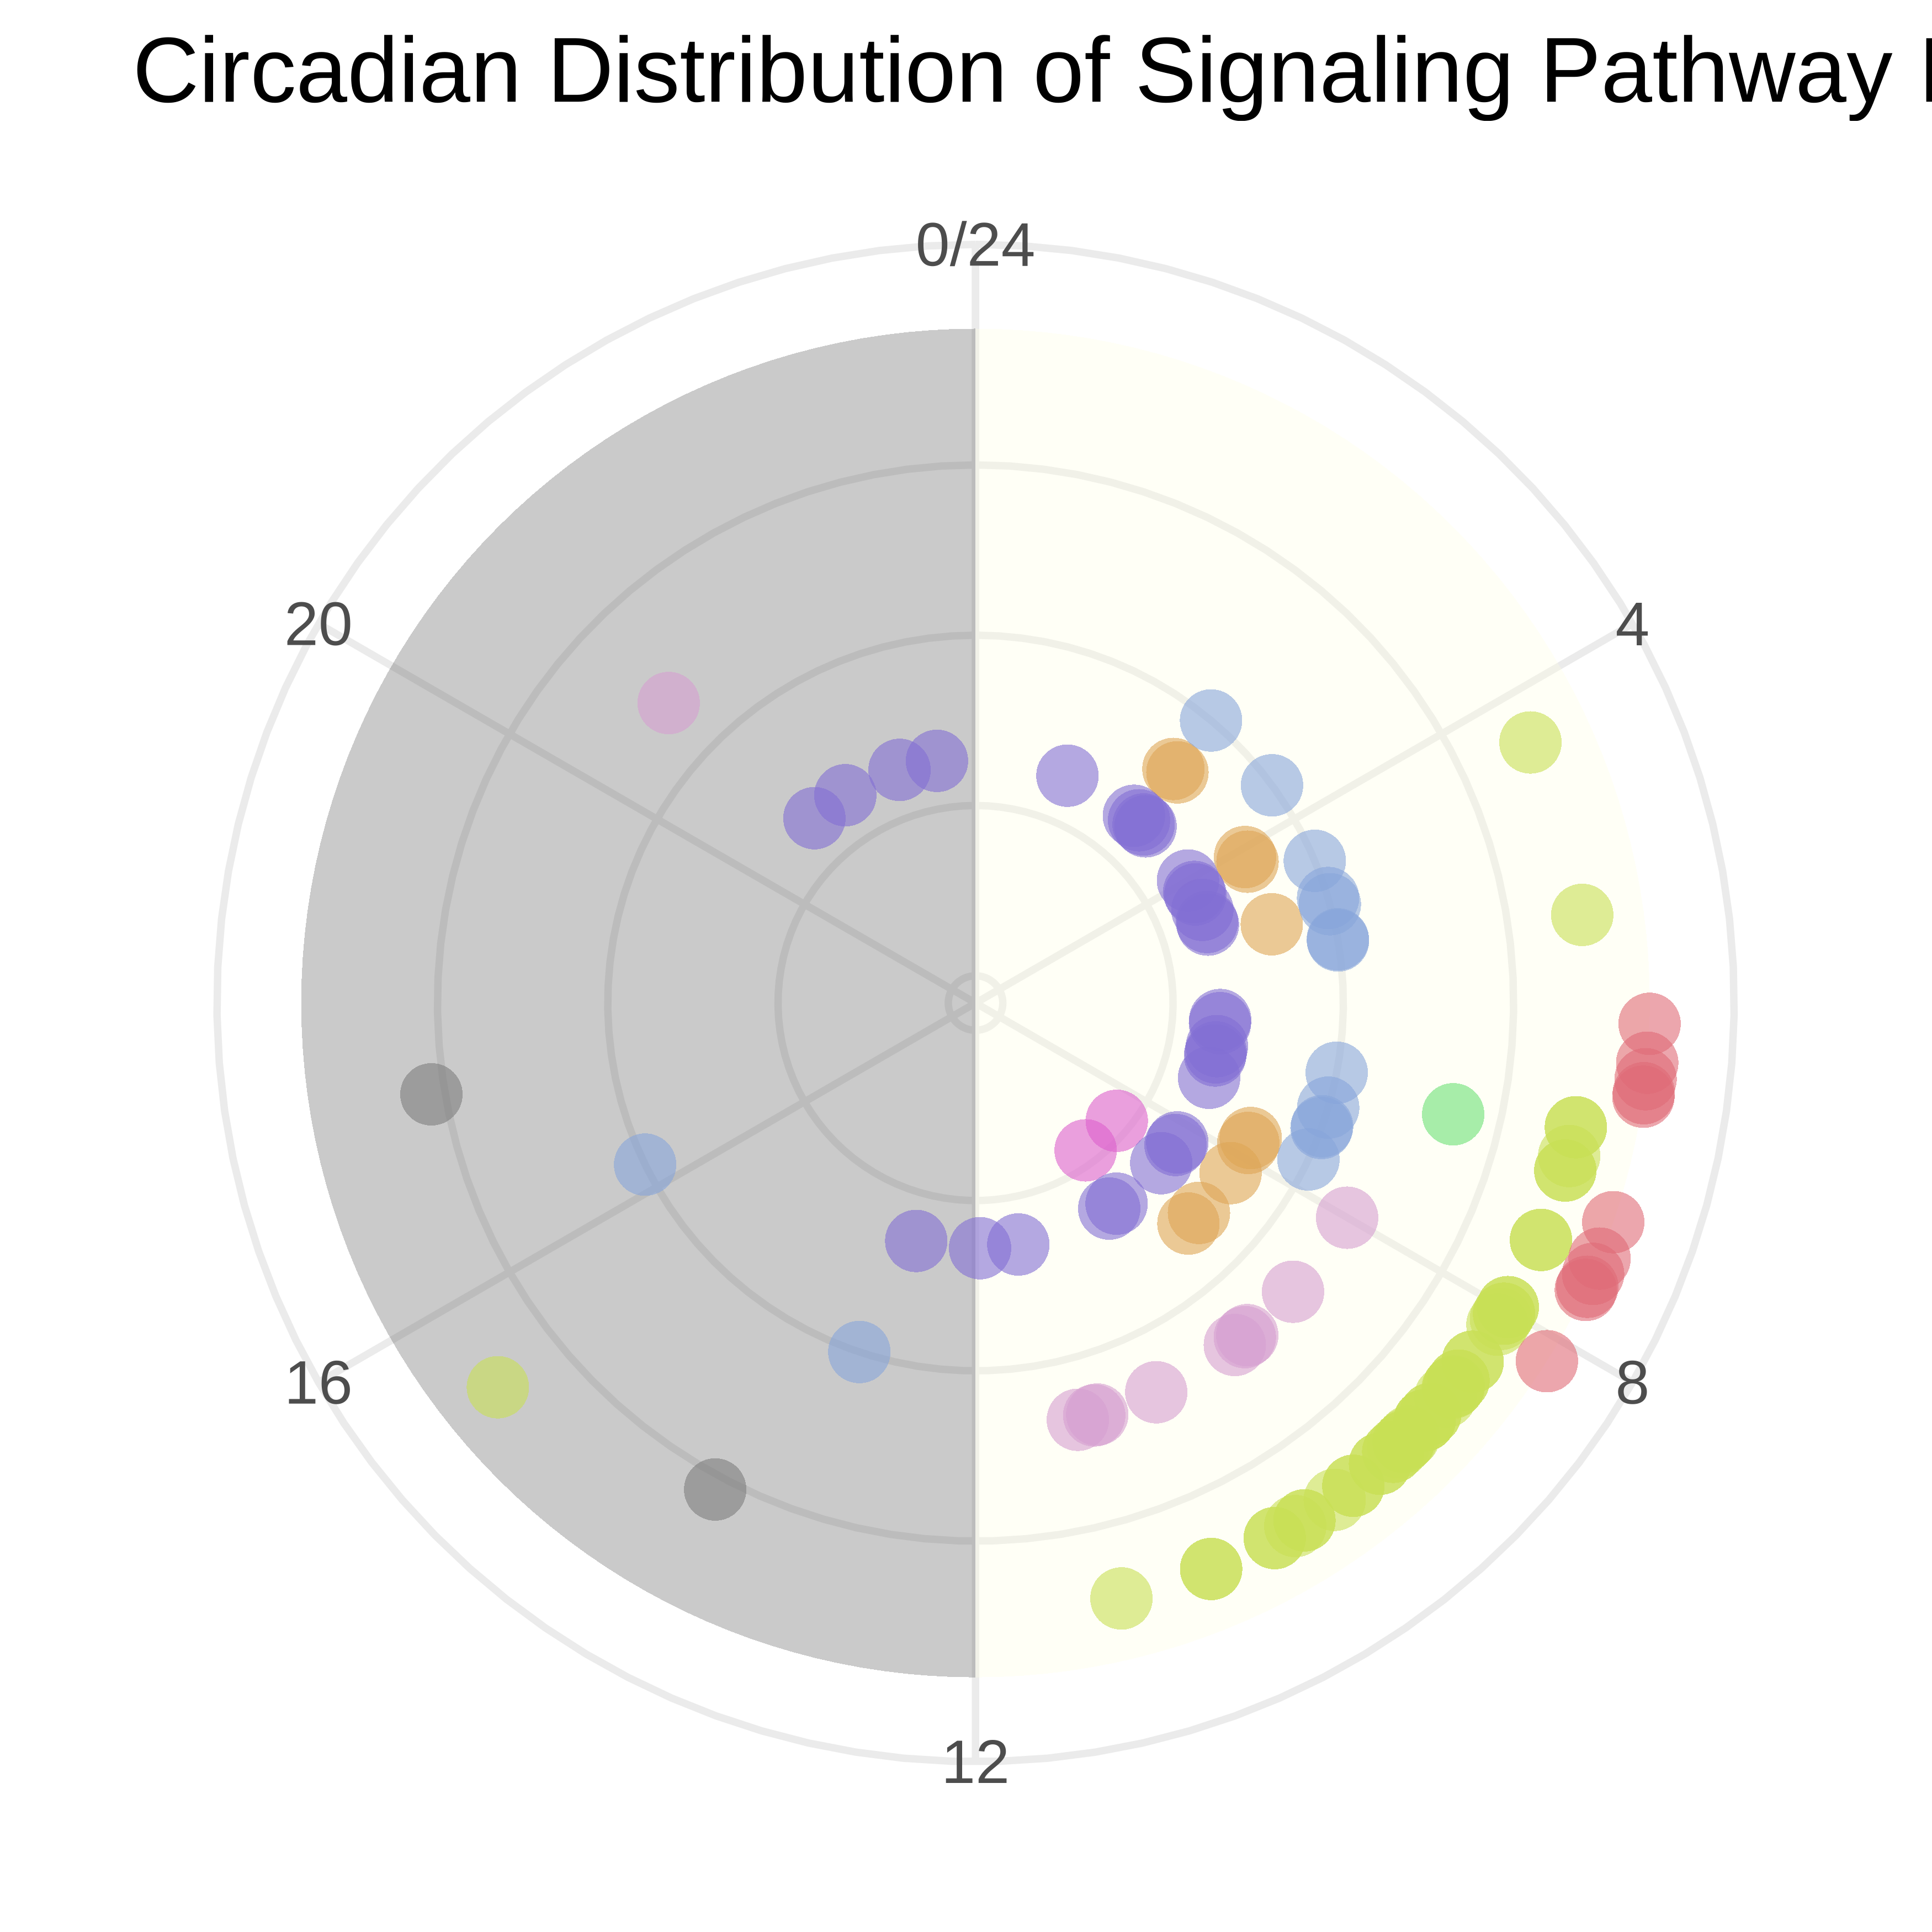

In [199]:
# Load required packages
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)

#-----------------------------------------------------------
# 1. Read in your data
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/MTLD_combined.csv")
FlyPhoneDB <- read_excel("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from WTLD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
# Use relationship = "many-to-many" to suppress warnings.
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
# Define a function to compute the minimal circadian difference (wrap-around)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)



combined_df <- combined_df %>% 
  # after your two inner_joins…
  rename(
    Signaling_Pathway = `Receptor Pathway`,
    ligand_FBGN        = `Ligand FBgn`,
    receptor_FBGN      = `Receptor FBgn`
  )
circadian_diff <- function(lag1, lag2) {
  d <- abs(lag1 - lag2)
  pmin(d, 24 - d)
}

combined_df <- combined_df %>%
  mutate(
    phase_diff = circadian_diff(ligand_LAG, receptor_LAG)
  ) %>%
  filter(phase_diff <= 4) %>%
  mutate(
    avg_lag = (ligand_LAG + receptor_LAG) / 2
    # or use your previous avg_ligand_LAG if you prefer
  )
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4","ZT4-8","ZT8-12","ZT12-16","ZT16-20","ZT20-24")
bin_colors <- c("yellow3","#707000","#505010","#707070","#404040","black")
names(bin_colors) <- bin_labels

combined_df <- combined_df %>%
  mutate(
    time_bin = cut(
      avg_lag, breaks = bin_breaks, labels = bin_labels,
      include.lowest = TRUE, right = FALSE
    ),
    bin_col = bin_colors[time_bin]
  )
library(dplyr)
library(ggplot2)
library(forcats)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Rename FlyPhoneDB pathway column if needed:
# ─────────────────────────────────────────────────────────────────────────────
# combined_df <- combined_df %>%
#   rename(Signaling_Pathway = `Receptor Pathway`)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define your fixed “core” pathways (13 total, no Hedgehog)
# ─────────────────────────────────────────────────────────────────────────────
core_order <- c(
    "RTK/Growth factors",
    "Cadherins & IgSF",
    "FGFR signaling pathway",
    #"INSULIN signaling pathway",
    "Neuropeptide signaling",
    "Eph/Ephrin signaling",
    "WNT signaling pathway",
    #"EGFR signaling pathway",
    "Axon-guidance cues",
    "TGF beta signaling pathway",
    "PVR RTK signaling pathway",
    "NOTCH signaling pathway",
    "Toll signaling pathway"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) SCENIC‐style base palette — take the first 13 for your core pathways
# ─────────────────────────────────────────────────────────────────────────────
base_colors <- c(
  "#E06B77", "#C8E055", "#7E7E7E", "#6CE177", "#D69ED1",
  "#87A5DB", "#DDA555", "#836ED3", "#DC60CD", "#6ABEC9",
  "#C7DA9C", "#A13FE1", "#CFA79E", "#7AE2BF", "#5ABEF9",
  "#EA4E4E", "#286ED8"
)
core_colors <- setNames(base_colors[seq_along(core_order)], core_order)
extras      <- setdiff(unique(combined_df$Signaling_Pathway), core_order)
extra_colors<- setNames(rep("grey50", length(extras)), extras)
path_pal    <- c(core_colors, extra_colors)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
inner_hole <- 6     # blank center radius
ring_width <- 1.8   # spacing between rings

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build the plotting dataframe
# ─────────────────────────────────────────────────────────────────────────────
plot_df <- combined_df %>%
  filter(Signaling_Pathway %in% core_order) %>%
  mutate(
    avg_lag        = (ligand_LAG + receptor_LAG) / 2,
    phase_deg      = 360 * (avg_lag / 24),
    pathway_factor = factor(Signaling_Pathway, levels = core_order),
    ring_id        = as.numeric(pathway_factor),
    # ◀◀ ZERO-BASED radius: first ring sits at inner_hole
    radius         = inner_hole + (ring_id - 1) * ring_width
  )

# ◀◀ Recompute max_r so the outer edge matches the new zero-based radius
max_r <- inner_hole + (length(core_order)) * ring_width

# ─────────────────────────────────────────────────────────────────────────────
# 6) Draw the SCENIC‐style donut plot
# ─────────────────────────────────────────────────────────────────────────────
ggplot(plot_df, aes(x = phase_deg, y = radius, color = pathway_factor)) +
  # day/night background
#  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
#           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin = 180, xmax = 360, ymin = -Inf, ymax = Inf,
           fill = "gray30", alpha = 0.3) +

  # big solid circles
  geom_point(
    shape    = 16,
    size     = 7.3,
    alpha    = 0.6,
    position = position_jitter(height = 0.0)
  ) +
  # polar coordinates
  coord_polar(theta = "x", start = 0, clip = "off") +
  # 0–24 h angular axis
  scale_x_continuous(
    limits = c(0, 360),
    breaks = seq(0, 360, by = 60),
    labels = seq(0, 24, by = 4)
  ) +
  # reverse radial axis: carve out a hole [0..inner_hole]
  scale_y_reverse(
    limits = c(max_r, inner_hole),
    expand = c(0, 0)
  ) +
  # fixed color mapping for pathways
  scale_color_manual(
    name   = "Pathway",
    values = path_pal,
    guide  = guide_legend(override.aes = list(size = 6))
  ) +
  # clean theme
  theme_minimal(base_size = 20) +
  theme(
    axis.title       = element_blank(),
    axis.text.y      = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position  = "none"
  ) +
  labs(
    title = "Circadian Distribution of Signaling Pathway Interactions"
  )


# MTDD

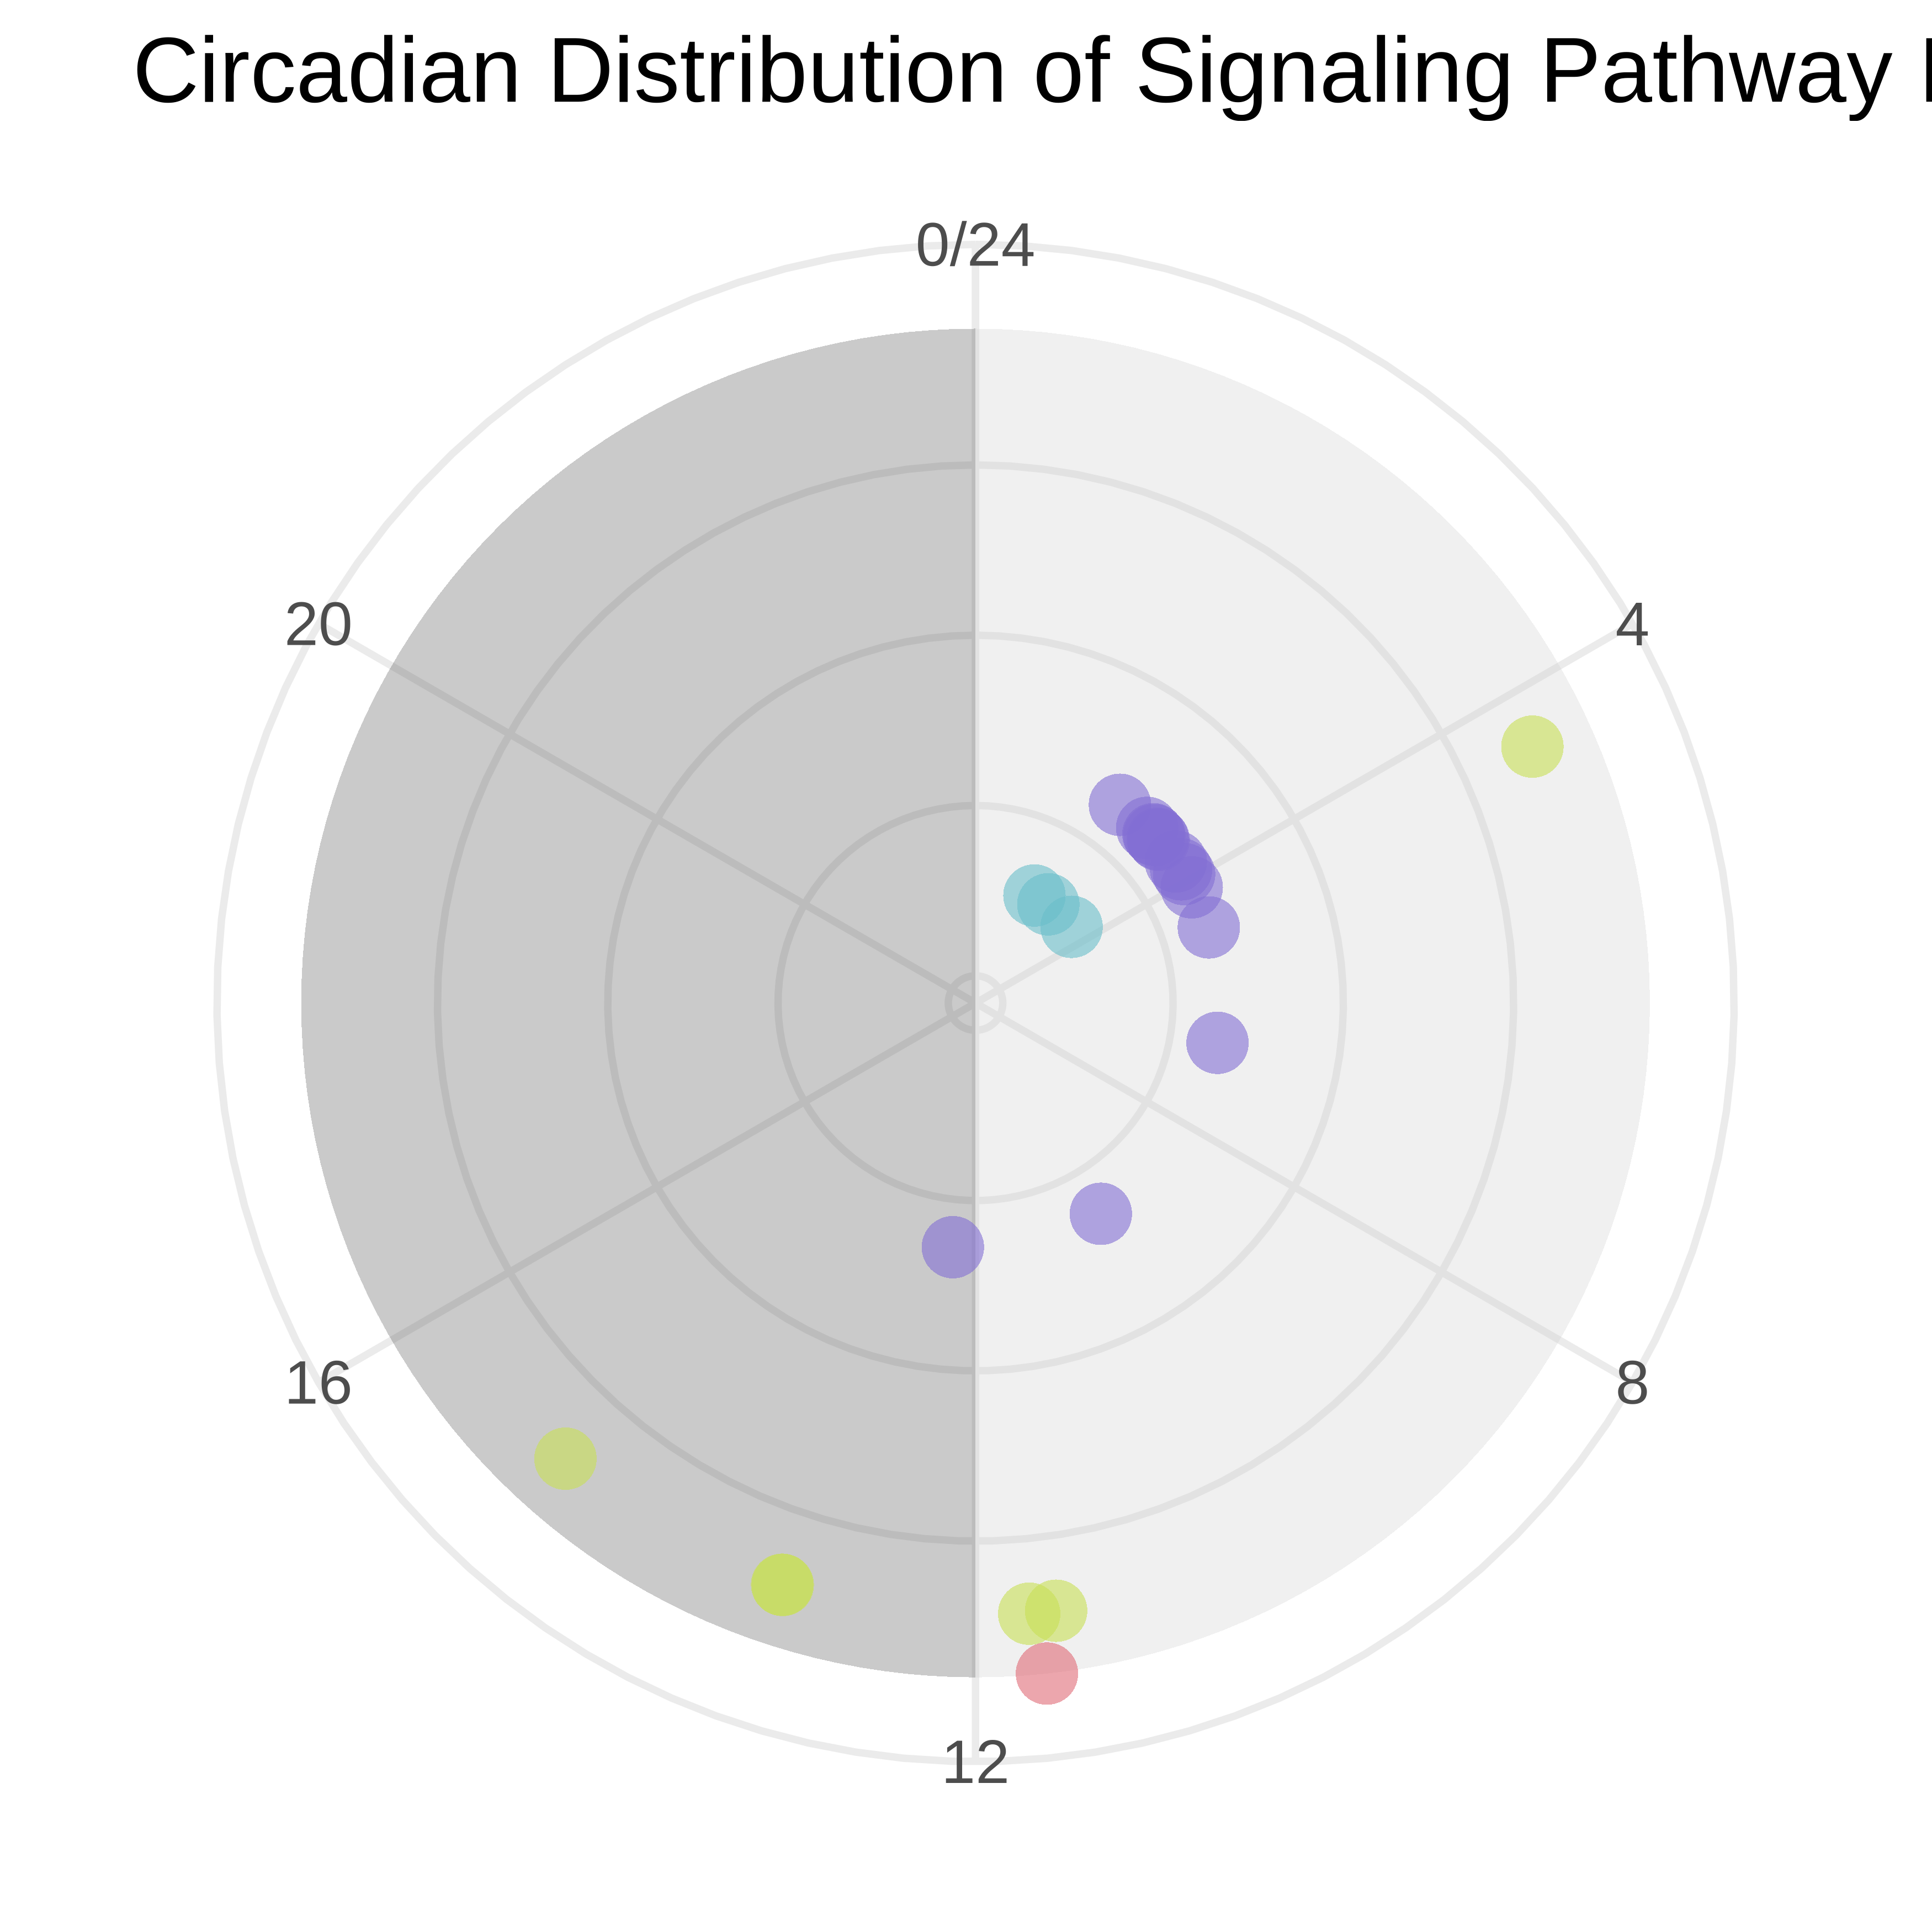

In [201]:
# Load required packages
library(dplyr)
library(tidyr)
library(readxl)
library(circlize)
library(scales)
library(ComplexHeatmap)

#-----------------------------------------------------------
# 1. Read in your data
WTLD <- read.csv("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/MTDD_combined.csv")
FlyPhoneDB <- read_excel("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27/FlyPhoneDB - ligand_receptor_pair_fly_phone_2024-06-04 152106.xlsx",skip = 1)

#-----------------------------------------------------------
# 2. Filter out "Unannotated" cell types from WTLD
WTLD <- WTLD %>% filter(cell_type != "Unannotated")

#-----------------------------------------------------------
# 3. Merge data to obtain ligand and receptor information
# Use relationship = "many-to-many" to suppress warnings.
ligand_df <- FlyPhoneDB %>% 
  inner_join(WTLD, by = c("Ligand Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(ligand_cell_type = cell_type,
         ligand_LAG = avg_phase)

combined_df <- ligand_df %>% 
  inner_join(WTLD, by = c("Receptor Gene Symbol" = "CycID"), relationship = "many-to-many") %>%
  rename(receptor_cell_type = cell_type,
         receptor_LAG = avg_phase)

#-----------------------------------------------------------
# 4. Filter for valid interactions (phase difference ≤ 4 hours)
# Define a function to compute the minimal circadian difference (wrap-around)
circadian_diff <- function(lag1, lag2) {
  diff <- abs(lag1 - lag2)
  pmin(diff, 24 - diff)
}

combined_df <- combined_df %>%
  mutate(phase_diff = circadian_diff(ligand_LAG, receptor_LAG)) %>%
  filter(phase_diff <= 4)



combined_df <- combined_df %>% 
  # after your two inner_joins…
  rename(
    Signaling_Pathway = `Receptor Pathway`,
    ligand_FBGN        = `Ligand FBgn`,
    receptor_FBGN      = `Receptor FBgn`
  )
circadian_diff <- function(lag1, lag2) {
  d <- abs(lag1 - lag2)
  pmin(d, 24 - d)
}

combined_df <- combined_df %>%
  mutate(
    phase_diff = circadian_diff(ligand_LAG, receptor_LAG)
  ) %>%
  filter(phase_diff <= 4) %>%
  mutate(
    avg_lag = (ligand_LAG + receptor_LAG) / 2
    # or use your previous avg_ligand_LAG if you prefer
  )
bin_breaks <- c(0, 4, 8, 12, 16, 20, 24)
bin_labels <- c("ZT0-4","ZT4-8","ZT8-12","ZT12-16","ZT16-20","ZT20-24")
bin_colors <- c("yellow3","#707000","#505010","#707070","#404040","black")
names(bin_colors) <- bin_labels

combined_df <- combined_df %>%
  mutate(
    time_bin = cut(
      avg_lag, breaks = bin_breaks, labels = bin_labels,
      include.lowest = TRUE, right = FALSE
    ),
    bin_col = bin_colors[time_bin]
  )
library(dplyr)
library(ggplot2)
library(forcats)

# ─────────────────────────────────────────────────────────────────────────────
# 1) Rename FlyPhoneDB pathway column if needed:
# ─────────────────────────────────────────────────────────────────────────────
# combined_df <- combined_df %>%
#   rename(Signaling_Pathway = `Receptor Pathway`)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Define your fixed “core” pathways (13 total, no Hedgehog)
# ─────────────────────────────────────────────────────────────────────────────
core_order <- c(
    "RTK/Growth factors",
    "Cadherins & IgSF",
    "FGFR signaling pathway",
    #"INSULIN signaling pathway",
    "Neuropeptide signaling",
    "Eph/Ephrin signaling",
    "WNT signaling pathway",
    #"EGFR signaling pathway",
    "Axon-guidance cues",
    "TGF beta signaling pathway",
    "PVR RTK signaling pathway",
    "NOTCH signaling pathway",
    "Toll signaling pathway"
)

# ─────────────────────────────────────────────────────────────────────────────
# 3) SCENIC‐style base palette — take the first 13 for your core pathways
# ─────────────────────────────────────────────────────────────────────────────
base_colors <- c(
  "#E06B77", "#C8E055", "#7E7E7E", "#6CE177", "#D69ED1",
  "#87A5DB", "#DDA555", "#836ED3", "#DC60CD", "#6ABEC9",
  "#C7DA9C", "#A13FE1", "#CFA79E", "#7AE2BF", "#5ABEF9",
  "#EA4E4E", "#286ED8"
)
core_colors <- setNames(base_colors[seq_along(core_order)], core_order)
extras      <- setdiff(unique(combined_df$Signaling_Pathway), core_order)
extra_colors<- setNames(rep("grey50", length(extras)), extras)
path_pal    <- c(core_colors, extra_colors)

# ─────────────────────────────────────────────────────────────────────────────
# 4) Plotting parameters
# ─────────────────────────────────────────────────────────────────────────────
inner_hole <- 6     # blank center radius
ring_width <- 1.8   # spacing between rings

# ─────────────────────────────────────────────────────────────────────────────
# 5) Build the plotting dataframe
# ─────────────────────────────────────────────────────────────────────────────
plot_df <- combined_df %>%
  filter(Signaling_Pathway %in% core_order) %>%
  mutate(
    avg_lag        = (ligand_LAG + receptor_LAG) / 2,
    phase_deg      = 360 * (avg_lag / 24),
    pathway_factor = factor(Signaling_Pathway, levels = core_order),
    ring_id        = as.numeric(pathway_factor),
    # ◀◀ ZERO-BASED radius: first ring sits at inner_hole
    radius         = inner_hole + (ring_id - 1) * ring_width
  )

# ◀◀ Recompute max_r so the outer edge matches the new zero-based radius
max_r <- inner_hole + (length(core_order)) * ring_width

# ─────────────────────────────────────────────────────────────────────────────
# 6) Draw the SCENIC‐style donut plot
# ─────────────────────────────────────────────────────────────────────────────
ggplot(plot_df, aes(x = phase_deg, y = radius, color = pathway_factor)) +
  # day/night background
#  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
#           fill = "lightyellow", alpha = 0.3) +
  annotate("rect", xmin =   0, xmax = 180, ymin = -Inf, ymax = Inf,
           fill = "gray80", alpha = 0.3) +
  annotate("rect", xmin = 180, xmax = 360, ymin = -Inf, ymax = Inf,
           fill = "gray30", alpha = 0.3) +

  # big solid circles
  geom_point(
    shape    = 16,
    size     = 7.3,
    alpha    = 0.6,
    position = position_jitter(height = 0.0)
  ) +
  # polar coordinates
  coord_polar(theta = "x", start = 0, clip = "off") +
  # 0–24 h angular axis
  scale_x_continuous(
    limits = c(0, 360),
    breaks = seq(0, 360, by = 60),
    labels = seq(0, 24, by = 4)
  ) +
  # reverse radial axis: carve out a hole [0..inner_hole]
  scale_y_reverse(
    limits = c(max_r, inner_hole),
    expand = c(0, 0)
  ) +
  # fixed color mapping for pathways
  scale_color_manual(
    name   = "Pathway",
    values = path_pal,
    guide  = guide_legend(override.aes = list(size = 6))
  ) +
  # clean theme
  theme_minimal(base_size = 20) +
  theme(
    axis.title       = element_blank(),
    axis.text.y      = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position  = "none"
  ) +
  labs(
    title = "Circadian Distribution of Signaling Pathway Interactions"
  )
